#  SPE DSEATS Africa Datathon 2025 - Well Classification

This notebook classifies 20 oil wells and estimates total oil production per reservoir using provided datasets.

## Objective
- Classify 20 wells by:
  - Reservoir Name
  - Reservoir Type (Saturated/Undersaturated)
  - Well Type (NF/GL)
  - Production Type (Steady/Unsteady)
  - GOR Trend (aSolGOR/bSolGOR/Combo)
  - Watercut Trend (Flat/Incr/Decr/Combo)
  - Oil PI Trend (Flat/Incr/Decr/Combo)
- Estimate total oil production (reservoir barrels) for five reservoirs (ACHI, KEMA, MAKO, DEPU, JANI)

## Workflow

-  Project Introduction & Objective
-  Import Libraries & Load Data
-  Data Cleaning & Preprocessing
-  Exploratory Data Analysis (EDA)
-  Feature Engineering (Watercut, GOR, PI)
-  Classify Wells Using Logic Rules
-  (Optional) Automate with ML Models
-  Export Classification File & Prepare Slides

# IMPORTING LIBRARIES AND LOADING DATASETS

## Importing Libraries

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import joblib

# Set visual theme
sns.set_style("darkgrid")  
sns.set_palette("Set2"),

## Loading Datasets

In [40]:
# Load datasets
well_df_raw = pd.read_csv("C:/Users/osuol/Desktop/SPE DSEAT/spe_africa_dseats_datathon_2025_wells_dataset.csv")
reservoir_df = pd.read_csv("C:/Users/osuol/Desktop/SPE DSEAT/reservoir_info.csv")

# Display shape and columns
well_df_raw.head()

PROD_DATE WELL_NAME  ON_STREAM_HRS BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0  15-Feb-14   Well_#1            0.0                             4,050   
1  16-Feb-14   Well_#1            0.0                             3,961   
2  17-Feb-14   Well_#1            0.0                             3,961   
3  18-Feb-14   Well_#1            0.0                             3,964   
4  19-Feb-14   Well_#1            0.0                             3,965   

   DOWNHOLE_TEMPERATURE (deg F) ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                   0         1.17951   
1                       189.945                   0         2.99440   
2                       190.004                   0         1.90349   
3                       190.020                   0         0.00000   
4                       190.107                   0        30.20760   

  WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.46                         50.864   
1                  328.601                         47.668   
2                  387.218                         48.962   
3                   308.98                         46.636   
4                  196.057                         47.297   

  CUMULATIVE_OIL_PROD (STB) CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                         0                                    0   
1                         0                                    0   
2                         0                                    0   
3                         0                                    0   
4                         0                                    0   

  CUMULATIVE_TOTAL_GAS_PROD (MSCF) CUMULATIVE_WATER_PROD (BBL)  
0                                0                           0  
1                                0                           0  
2                                0                           0  
3                                0                           0  
4                                0                           0

In [41]:
well_df_raw.shape

(7955, 13)

In [42]:
well_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PROD_DATE                             7955 non-null   object 
 1   WELL_NAME                             7955 non-null   object 
 2   ON_STREAM_HRS                         7955 non-null   float64
 3   BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955 non-null   object 
 4   DOWNHOLE_TEMPERATURE (deg F)          7955 non-null   float64
 5   ANNULUS_PRESS (PSI)                   7955 non-null   object 
 6   CHOKE_SIZE (%)                        7955 non-null   float64
 7   WELL_HEAD_PRESSURE (PSI)              7955 non-null   object 
 8   WELL_HEAD_TEMPERATURE (deg F)         7955 non-null   float64
 9   CUMULATIVE_OIL_PROD (STB)             7955 non-null   object 
 10  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  7955 non-null   object 
 11  CUMULATIVE_TOTAL_

In [43]:
reservoir_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Reservoir Name                            5 non-null      object 
 1   Initial Reservoir Pressure (PSI)          5 non-null      object 
 2   Bubble Point Pressure (PSI)               5 non-null      object 
 3   Current Average Reservoir Pressure (PSI)  5 non-null      object 
 4   Solution Gas-Oil-Ratio (SCF/BBL)          5 non-null      object 
 5   Formation Volume Factor (RB/STB)          5 non-null      float64
dtypes: float64(1), object(5)
memory usage: 372.0+ bytes


I noticed that some columns with numbers like pressures and production volumes are showing as `object` instead of numeric. This is likely because of comma separators.

I'll fix that by removing the commas and convert them to float so I can work with them properly later on.

# PREPROCESSING

## Cleaning and Formatting

In [44]:
# Convert PROD_DATE to datetime
well_df_raw['PROD_DATE'] = pd.to_datetime(well_df_raw['PROD_DATE'], format='%d-%b-%y')

In [45]:
# Removing commas,and converting to float
cols_to_clean = [ 'BOTTOMHOLE_FLOWING_PRESSURE (PSI)',  'ANNULUS_PRESS (PSI)',  'WELL_HEAD_PRESSURE (PSI)', 'CUMULATIVE_OIL_PROD (STB)', 'CUMULATIVE_FORMATION_GAS_PROD (MSCF)', 'CUMULATIVE_WATER_PROD (BBL)']
for col in cols_to_clean:
    well_df_raw[col] = well_df_raw[col].astype(str).str.replace(",", "").astype(float)

# Clean reservoir_df columns
res_cols_to_clean = [
    'Initial Reservoir Pressure (PSI)',
    'Bubble Point Pressure (PSI)',
    'Current Average Reservoir Pressure (PSI)',
    'Solution Gas-Oil-Ratio (SCF/BBL)',
    'Formation Volume Factor (RB/STB)'
]
for col in res_cols_to_clean:
    reservoir_df[col] = reservoir_df[col].astype(str).str.replace(",", "").astype(float)

In [46]:
well_df_raw.head()

PROD_DATE WELL_NAME  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
0 2014-02-15   Well_#1            0.0                             4050.0   
1 2014-02-16   Well_#1            0.0                             3961.0   
2 2014-02-17   Well_#1            0.0                             3961.0   
3 2014-02-18   Well_#1            0.0                             3964.0   
4 2014-02-19   Well_#1            0.0                             3965.0   

   DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
0                       189.866                  0.0         1.17951   
1                       189.945                  0.0         2.99440   
2                       190.004                  0.0         1.90349   
3                       190.020                  0.0         0.00000   
4                       190.107                  0.0        30.20760   

   WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
0                   482.460                         50.864   
1                   328.601                         47.668   
2                   387.218                         48.962   
3                   308.980                         46.636   
4                   196.057                         47.297   

   CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
0                        0.0                                   0.0   
1                        0.0                                   0.0   
2                        0.0                                   0.0   
3                        0.0                                   0.0   
4                        0.0                                   0.0   

  CUMULATIVE_TOTAL_GAS_PROD (MSCF)  CUMULATIVE_WATER_PROD (BBL)  
0                                0                          0.0  
1                                0                          0.0  
2                                0                          0.0  
3                                0                          0.0  
4                                0                          0.0

In [47]:
well_df_raw.describe(include='all')

PROD_DATE WELL_NAME  ON_STREAM_HRS  \
count                            7955      7955    7955.000000   
unique                            NaN        20            NaN   
top                               NaN  Well_#20            NaN   
freq                              NaN       820            NaN   
mean    2013-08-26 16:25:49.516027648       NaN      21.623497   
min               2011-02-17 00:00:00       NaN       0.000000   
25%               2012-08-02 00:00:00       NaN      24.000000   
50%               2013-06-25 00:00:00       NaN      24.000000   
75%               2014-10-01 00:00:00       NaN      24.000000   
max               2016-08-12 00:00:00       NaN      25.000000   
std                               NaN       NaN       6.567826   

        BOTTOMHOLE_FLOWING_PRESSURE (PSI)  DOWNHOLE_TEMPERATURE (deg F)  \
count                         7955.000000                   7955.000000   
unique                                NaN                           NaN   
top                                   NaN                           NaN   
freq                                  NaN                           NaN   
mean                          2613.811816                    168.757429   
min                              0.000000                      0.000000   
25%                           2195.000000                    150.228500   
50%                           2465.000000                    158.624000   
75%                           3067.000000                    202.600000   
max                           4096.000000                    212.153000   
std                            687.600640                     31.917787   

        ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  WELL_HEAD_PRESSURE (PSI)  \
count           7955.000000     7955.000000               7955.000000   
unique                  NaN             NaN                       NaN   
top                     NaN             NaN                       NaN   
freq                    NaN             NaN                       NaN   
mean             471.339542       56.155295                212.574151   
min                0.000000        0.000000                  0.000000   
25%                4.199000       28.130855                 68.661500   
50%              301.247000       51.068030                113.718000   
75%              981.329000       99.800950                161.176500   
max             1639.040000      100.000000               1787.760000   
std              481.638340       34.975408                282.193044   

        WELL_HEAD_TEMPERATURE (deg F)  CUMULATIVE_OIL_PROD (STB)  \
count                     7955.000000               7.955000e+03   
unique                            NaN                        NaN   
top                               NaN                        NaN   
freq                              NaN                        NaN   
mean                        86.836365               1.725855e+05   
min                          0.000000               0.000000e+00   
25%                         80.677500               4.769100e+04   
50%                         88.364000               1.092950e+05   
75%                         96.770500               2.424885e+05   
max                        182.157000               1.129301e+06   
std                         22.738615               1.740827e+05   

        CUMULATIVE_FORMATION_GAS_PROD (MSCF) CUMULATIVE_TOTAL_GAS_PROD (MSCF)  \
count                           7.955000e+03                             7955   
unique                                   NaN                             7040   
top                                      NaN                                0   
freq                                     NaN                              396   
mean                            1.456235e+05                              NaN   
min                             0.000000e+00                              NaN   
25%                             3.854150e+04                             

In [48]:
reservoir_df, reservoir_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Reservoir Name                            5 non-null      object 
 1   Initial Reservoir Pressure (PSI)          5 non-null      float64
 2   Bubble Point Pressure (PSI)               5 non-null      float64
 3   Current Average Reservoir Pressure (PSI)  5 non-null      float64
 4   Solution Gas-Oil-Ratio (SCF/BBL)          5 non-null      float64
 5   Formation Volume Factor (RB/STB)          5 non-null      float64
dtypes: float64(5), object(1)
memory usage: 372.0+ bytes


(  Reservoir Name  Initial Reservoir Pressure (PSI)  \
 0           ACHI                            3500.0   
 1           KEMA                            4200.0   
 2           MAKO                            3500.0   
 3           DEPU                            2800.0   
 4           JANI                            4500.0   
 
    Bubble Point Pressure (PSI)  Current Average Reservoir Pressure (PSI)  \
 0                       3300.0                                    2700.0   
 1                       4000.0                                    3900.0   
 2                       3500.0                                    3000.0   
 3                       2800.0                                    2400.0   
 4                       4300.0                                    4200.0   
 
    Solution Gas-Oil-Ratio (SCF/BBL)  Formation Volume Factor (RB/STB)  
 0                             800.0                              1.20  
 1                             600.0                      

## Preprocessing

In order to keep the classification accurate, we will be making two copies of the raw data, one with minimal cleaning and processing for classification and the other one for preprocessing. In the course of processing, we noticed that the max bhp for the individual well were altered leading to inaccurate classification which my reduce the overall accuracy of our model 

In [49]:
#Preserve raw data for max BHP integrity
classification_df = well_df_raw.copy()
# Create working copy for preprocessing
well_df = well_df_raw.copy()

In [50]:
# Preserve raw data for classification with minimal cleaning
classification_df = classification_df.dropna(subset=['BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'WELL_NAME', 'PROD_DATE'])
classification_df = classification_df[classification_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] > 0]

In [51]:
# Filtering out non-production rows (ON_STREAM_HRS > 0) for production rates
well_df = well_df[well_df['ON_STREAM_HRS'] > 0]
# Calculating daily production rates
well_df['OIL_RATE'] = well_df['CUMULATIVE_OIL_PROD (STB)'].diff() / well_df['ON_STREAM_HRS']
well_df['GAS_RATE'] = well_df['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].diff() / well_df['ON_STREAM_HRS']
well_df['WATER_RATE'] = well_df['CUMULATIVE_WATER_PROD (BBL)'].diff() / well_df['ON_STREAM_HRS']
well_df['GOR'] = well_df['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'] / well_df['CUMULATIVE_OIL_PROD (STB)']
# Handling zero or negative pressures (assume invalid if <= 0) for preprocessed data
well_df = well_df[well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] > 0]
well_df = well_df[well_df['WELL_HEAD_PRESSURE (PSI)'] > 0]

In [52]:
# Initial cleaning for well_df for preprocessing
well_df = well_df.dropna(subset=['BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'WELL_NAME', 'PROD_DATE'])
well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] = pd.to_numeric(well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'], errors='coerce')
well_df = well_df[well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] > 0]
well_df = well_df.fillna({'OIL_RATE': 0, 'WATER_RATE': 0, 'GAS_RATE': 0, 'WELL_HEAD_PRESSURE (PSI)': 0})

## Features Engineering

In [53]:
# Derive initial features for well_df to support further calculations
well_df['GOR'] = np.where(well_df['OIL_RATE'] > 0, well_df['GAS_RATE'] / well_df['OIL_RATE'], 0)  # Gas-Oil Ratio
well_df['PI'] = np.where(well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] > 0, 
                        well_df['OIL_RATE'] / well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'], 0)  # Productivity Index
well_df['WATERCUT'] = np.where(well_df['OIL_RATE'] + well_df['WATER_RATE'] > 0, 
                              well_df['WATER_RATE'] / (well_df['OIL_RATE'] + well_df['WATER_RATE']) * 100, 0)  # Water Cut (%)
well_df['WATERCUT_DIFF'] = well_df['WATERCUT'].diff()  # Difference in watercut for trend
well_df['PI_DIFF'] = well_df['PI'].diff()  # Difference in PI for trend

In [54]:
# Calculate rolling averages and additional derived features for well_df
well_df['GOR_ROLLING'] = well_df['GOR'].rolling(window=30, min_periods=1).mean()
well_df['PI_ROLLING'] = well_df['PI'].rolling(window=30, min_periods=1).mean()
well_df['WATERCUT_ROLLING'] = well_df['WATERCUT'].rolling(window=30, min_periods=1).mean()
well_df['PRESSURE_RATIO'] = np.where(well_df['WELL_HEAD_PRESSURE (PSI)'] > 0, 
                                    well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] / well_df['WELL_HEAD_PRESSURE (PSI)'], 0)
well_df['MONTH'] = well_df['PROD_DATE'].dt.month
well_df['YEAR'] = well_df['PROD_DATE'].dt.year
well_df['DAY_OF_YEAR'] = well_df['PROD_DATE'].dt.dayofyear
well_df['OIL_RATE_ROLLING'] = well_df['OIL_RATE'].rolling(window=30, min_periods=1).mean()
well_df['GAS_RATE_ROLLING'] = well_df['GAS_RATE'].rolling(window=30, min_periods=1).mean()
well_df['WATER_RATE_ROLLING'] = well_df['WATER_RATE'].rolling(window=30, min_periods=1).mean()

In [17]:
# Aggregate features by well for machine learning input
well_features = well_df.groupby('WELL_NAME').agg({
    'BOTTOMHOLE_FLOWING_PRESSURE (PSI)': 'max',
    'OIL_RATE_ROLLING': 'mean',
    'GAS_RATE_ROLLING': 'mean',
    'WATER_RATE_ROLLING': 'mean',
    'GOR_ROLLING': 'mean',
    'PI_ROLLING': 'mean',
    'WATERCUT_ROLLING': 'mean',
    'PRESSURE_RATIO': 'mean',
    'MONTH': 'mean',
    'YEAR': 'mean',
    'DAY_OF_YEAR': 'mean'
}).reset_index() 

In [18]:
# checking for missing values
print("Missing Values in well_ df:")
print(well_df_raw.isna().sum(), end="\n\n")

print("Missing Values in classification_ df:")
print(classification_df.isna().sum())

Missing Values in well_ df:
PROD_DATE                               0
WELL_NAME                               0
ON_STREAM_HRS                           0
BOTTOMHOLE_FLOWING_PRESSURE (PSI)       0
DOWNHOLE_TEMPERATURE (deg F)            0
ANNULUS_PRESS (PSI)                     0
CHOKE_SIZE (%)                          0
WELL_HEAD_PRESSURE (PSI)                0
WELL_HEAD_TEMPERATURE (deg F)           0
CUMULATIVE_OIL_PROD (STB)               0
CUMULATIVE_FORMATION_GAS_PROD (MSCF)    0
CUMULATIVE_TOTAL_GAS_PROD (MSCF)        0
CUMULATIVE_WATER_PROD (BBL)             0
dtype: int64

Missing Values in classification_ df:
PROD_DATE                               0
WELL_NAME                               0
ON_STREAM_HRS                           0
BOTTOMHOLE_FLOWING_PRESSURE (PSI)       0
DOWNHOLE_TEMPERATURE (deg F)            0
ANNULUS_PRESS (PSI)                     0
CHOKE_SIZE (%)                          0
WELL_HEAD_PRESSURE (PSI)                0
WELL_HEAD_TEMPERATURE (deg F)         

In [19]:
# confirming the integrity of the well maxx BHP
print(pd.DataFrame(classification_df.groupby('WELL_NAME')['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].max()))

           BOTTOMHOLE_FLOWING_PRESSURE (PSI)
WELL_NAME                                   
Well_#1                               4096.0
Well_#10                              4051.0
Well_#11                              2521.0
Well_#12                              2557.0
Well_#13                              2246.0
Well_#14                              2857.0
Well_#15                              4032.0
Well_#16                              3836.0
Well_#17                              2304.0
Well_#18                              2621.0
Well_#19                              4036.0
Well_#2                               3735.0
Well_#20                              2858.0
Well_#3                               2985.0
Well_#4                               2340.0
Well_#5                               2933.0
Well_#6                               3797.0
Well_#7                               3821.0
Well_#8                               2681.0
Well_#9                               2333.0


After the preprocessing the well retains their integrity, the max_bhp of the raw data is the same

# EXPLORATORY DATA ANALYSIS (EDA)

## Production Trends

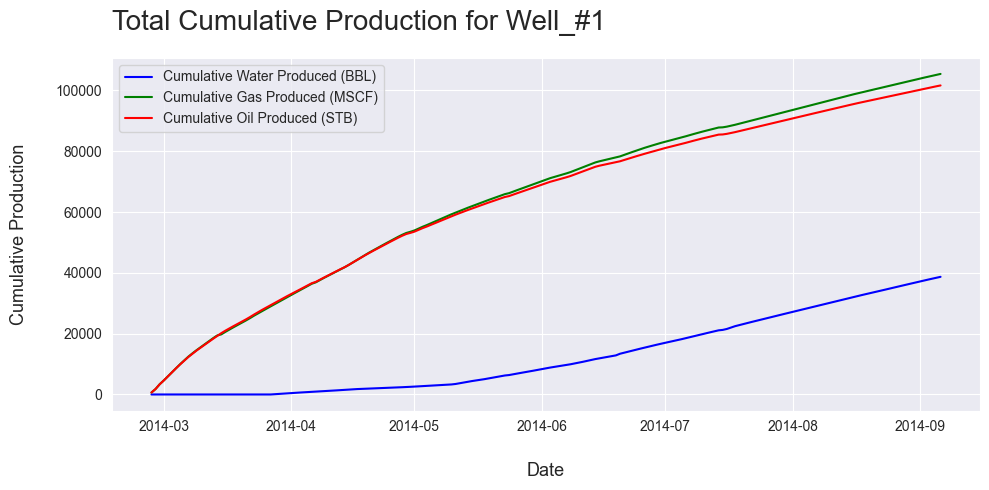

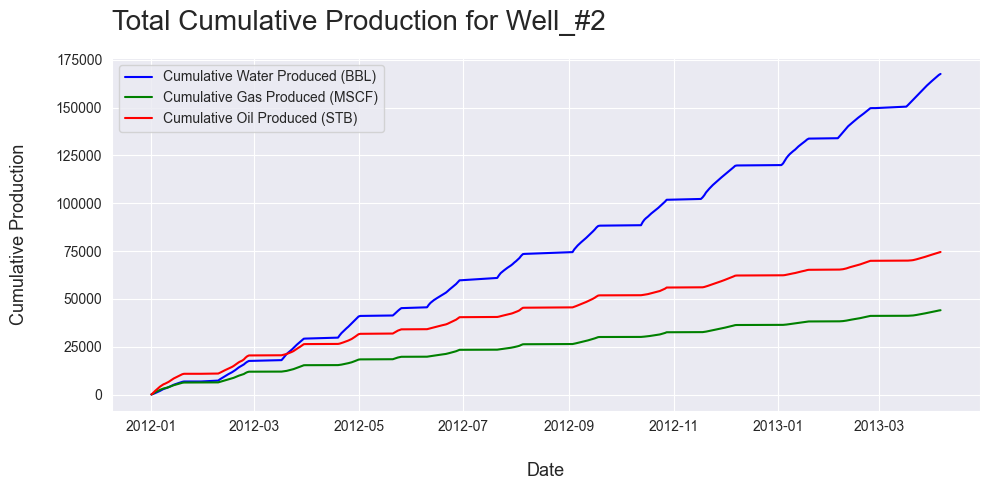

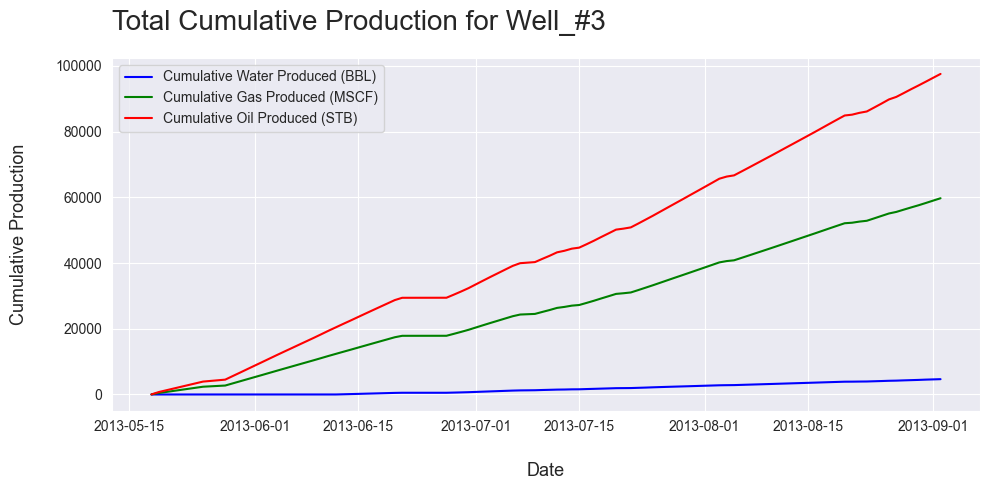

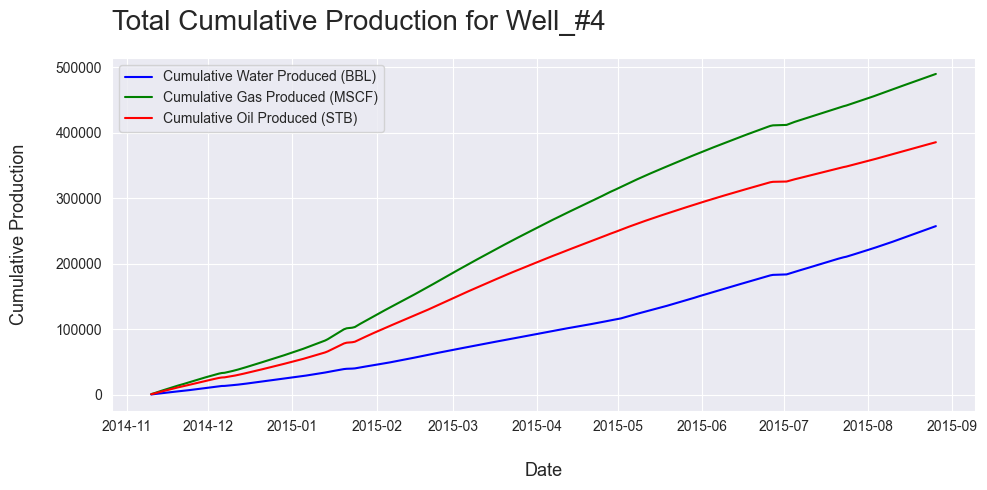

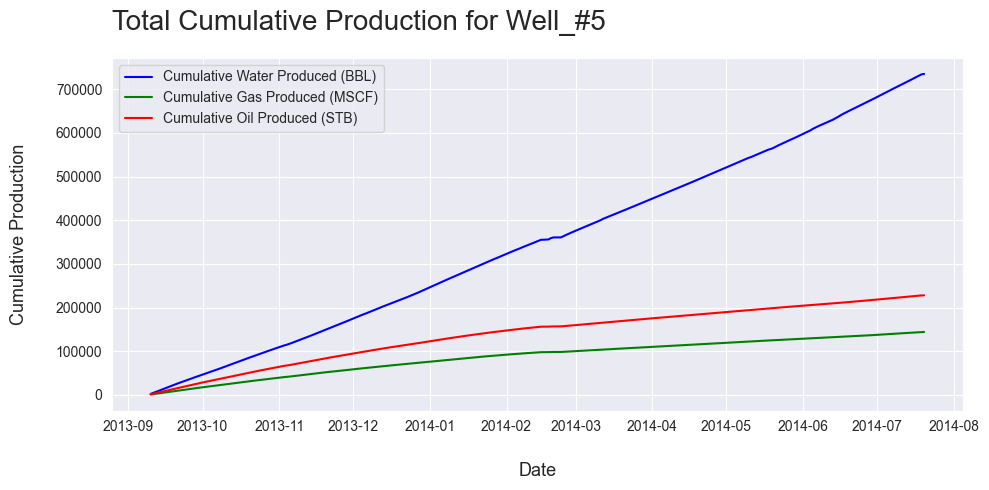

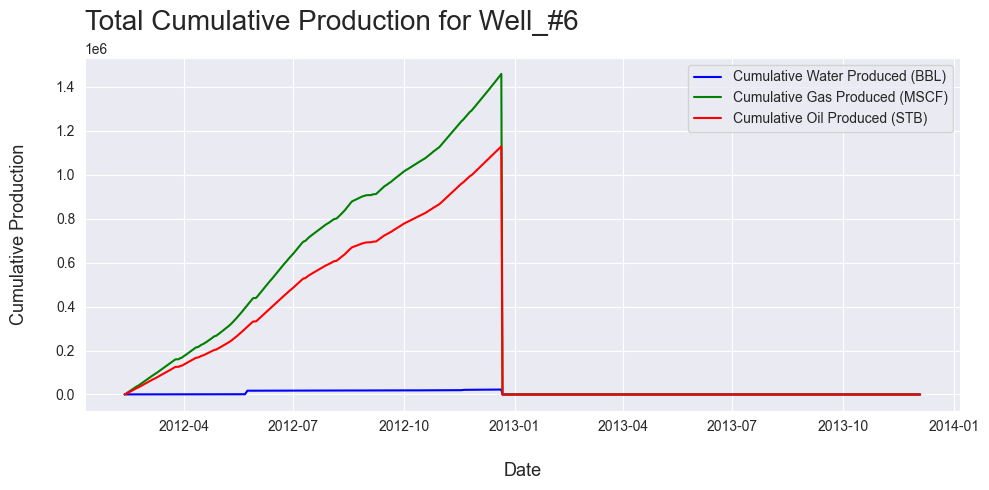

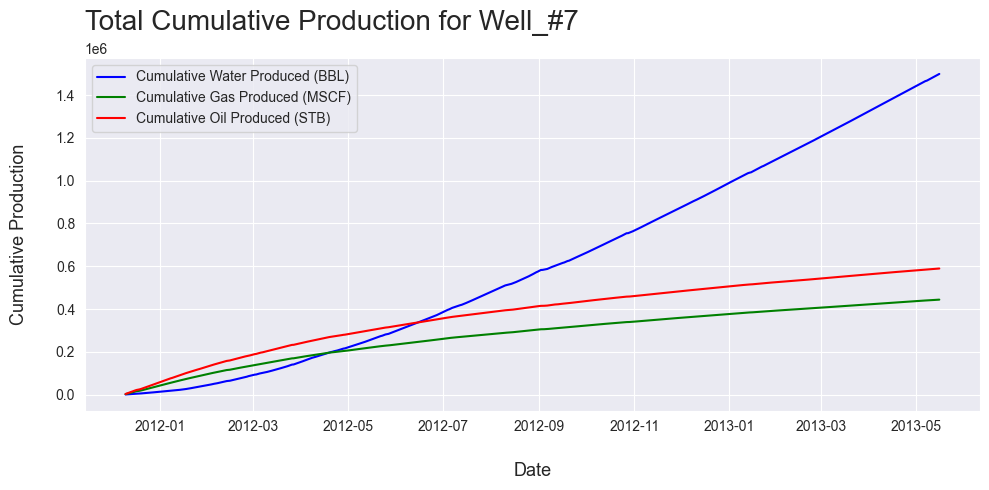

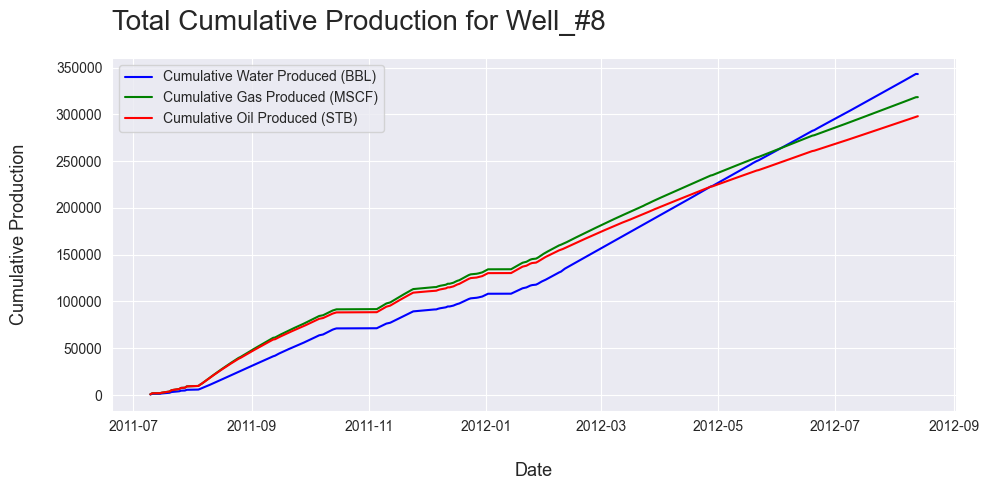

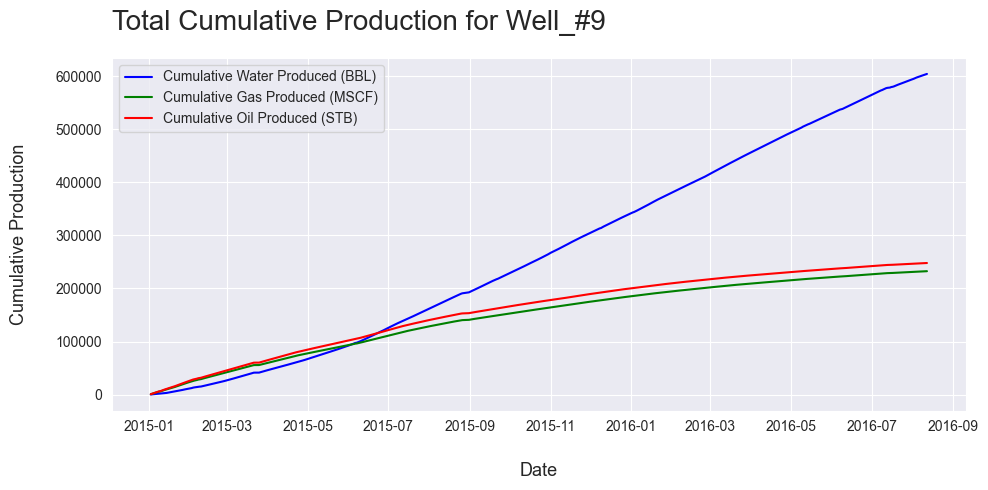

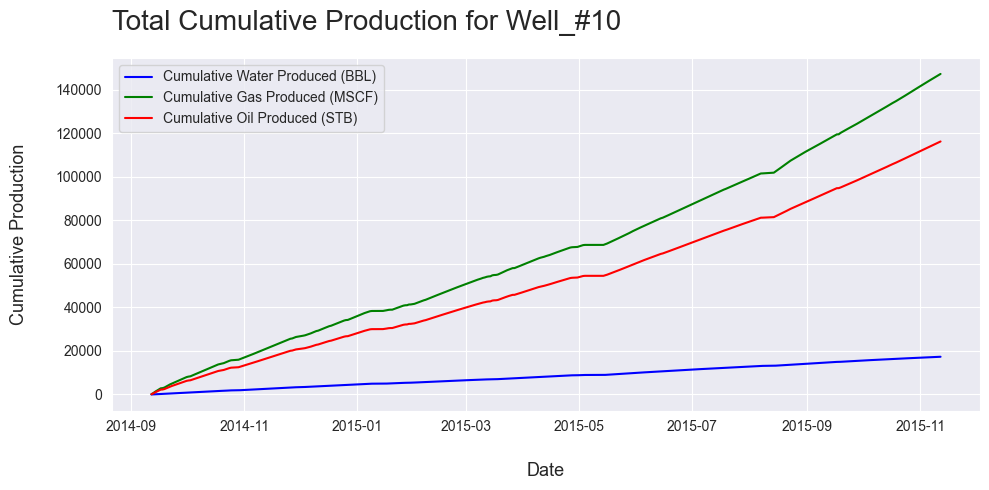

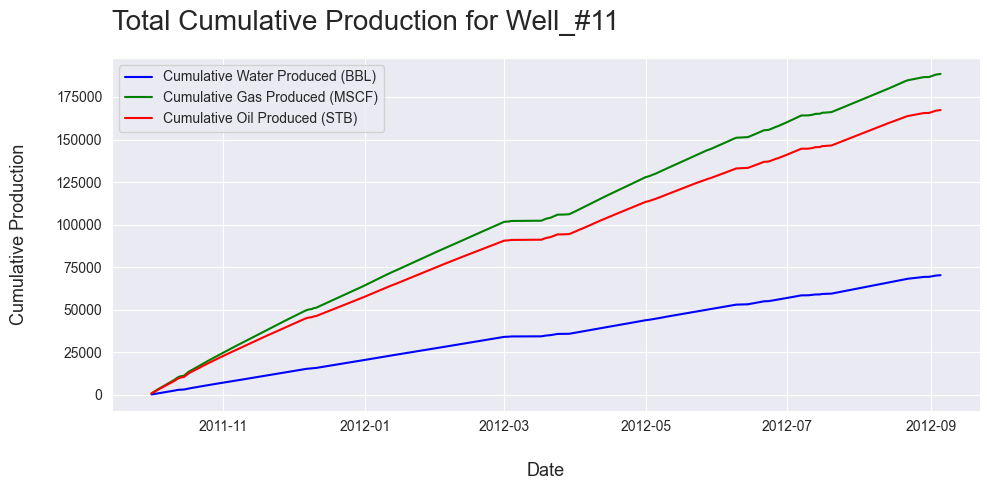

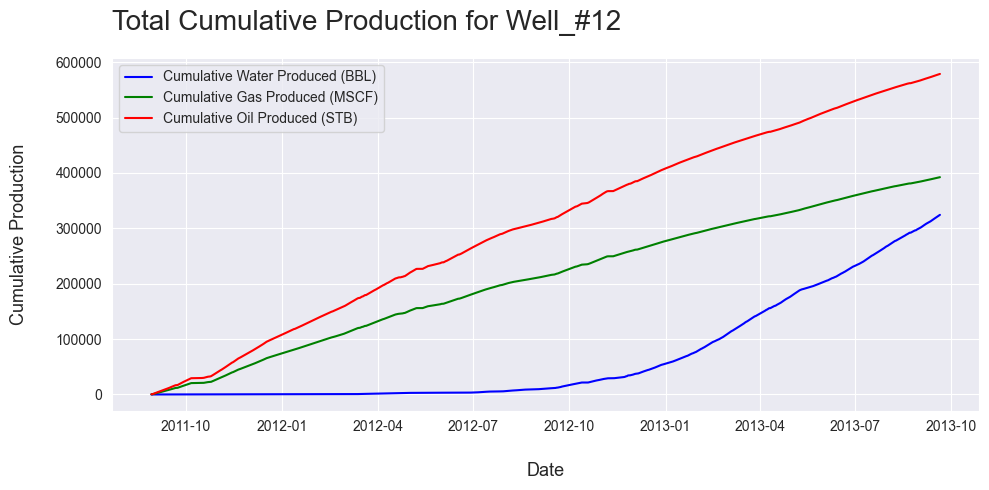

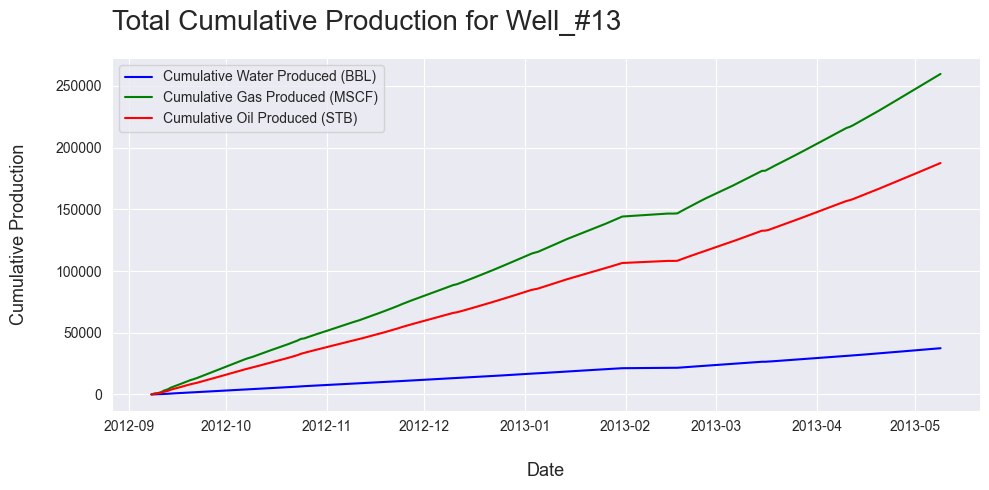

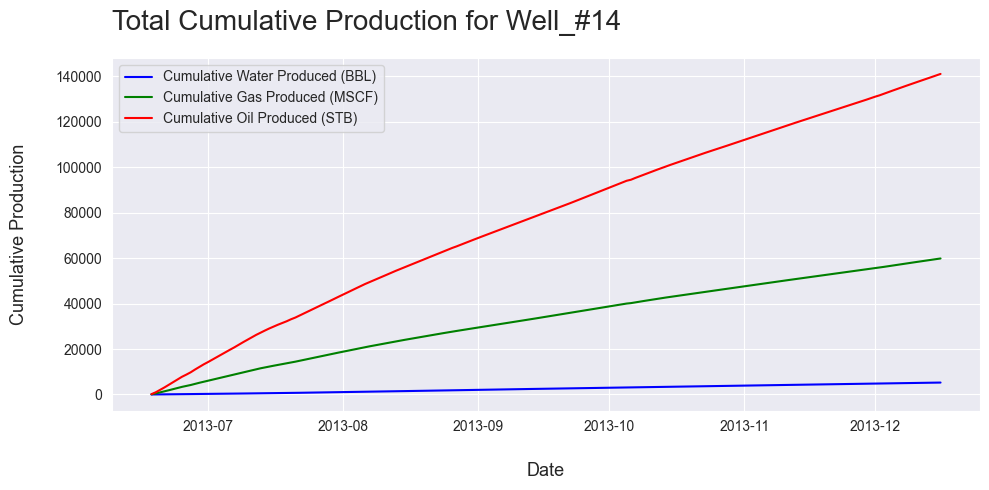

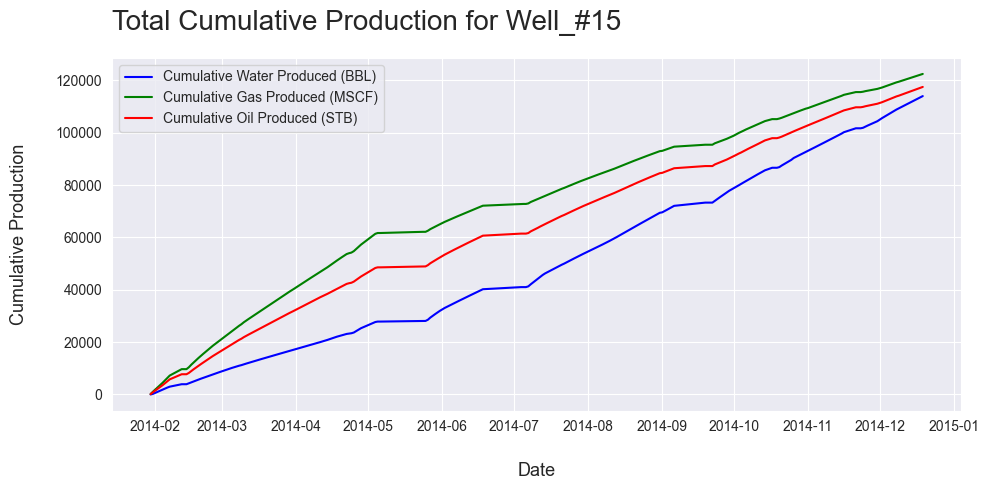

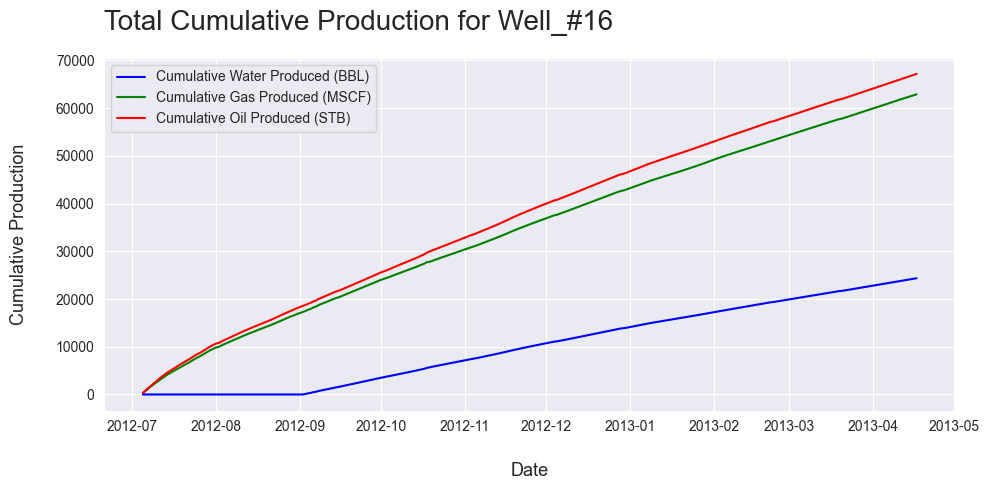

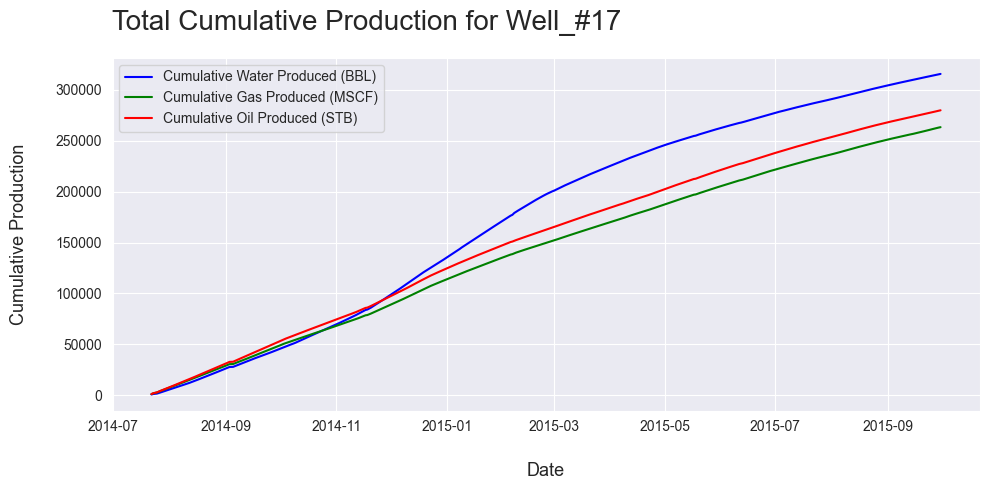

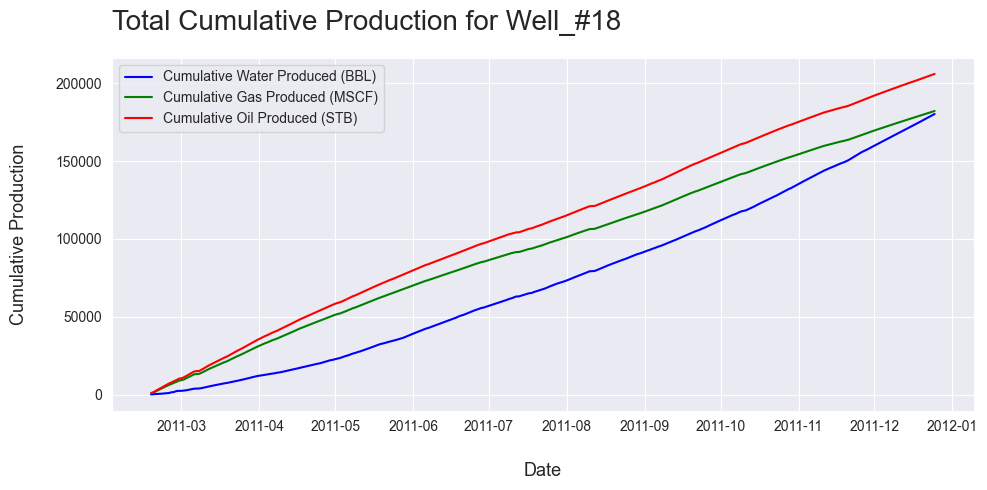

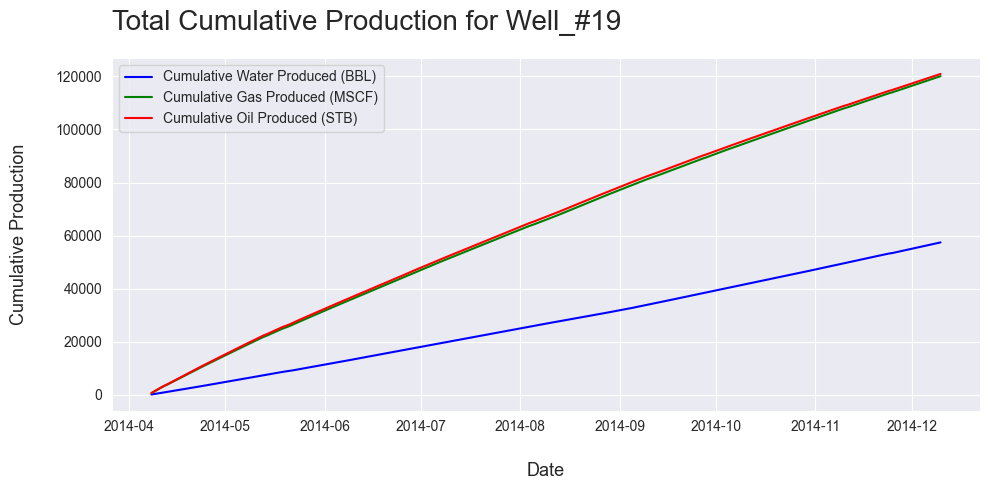

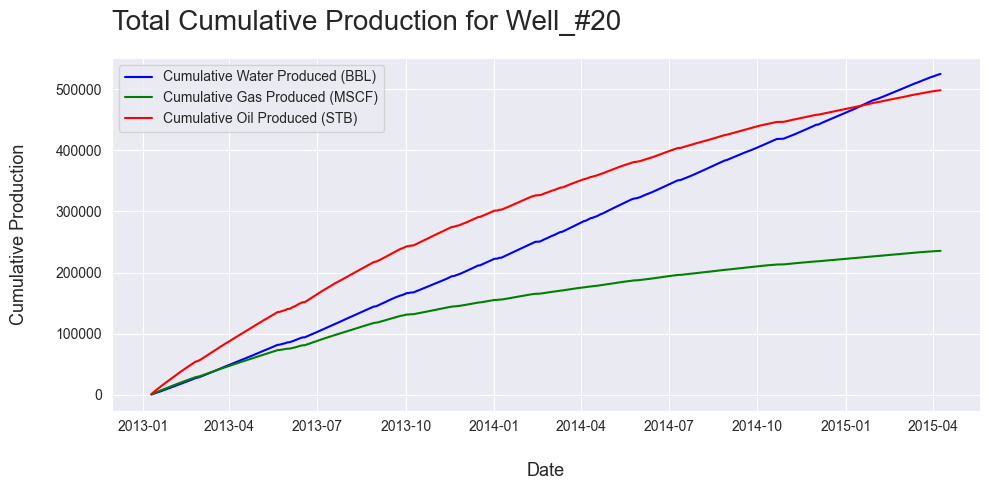

In [20]:
# Get unique well names
unique_wells = well_df['WELL_NAME'].unique()

# Process each well
for well_name in unique_wells:
    # Filter data for the current well
    well_data = well_df[well_df['WELL_NAME'] == well_name]

    # Plotting total cumulative production for the well
    plt.figure(figsize=(10, 5))
    plt.plot(well_data['PROD_DATE'], well_data['CUMULATIVE_WATER_PROD (BBL)'], label='Cumulative Water Produced (BBL)', color='blue')
    plt.plot(well_data['PROD_DATE'], well_data['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'], label='Cumulative Gas Produced (MSCF)', color='green')
    plt.plot(well_data['PROD_DATE'], well_data['CUMULATIVE_OIL_PROD (STB)'], label='Cumulative Oil Produced (STB)', color='red')
    plt.xlabel("Date", fontsize=13, labelpad=20)
    plt.ylabel("Cumulative Production", fontsize=13, labelpad=20)
    plt.title(f"Total Cumulative Production for {well_name}", fontsize=20, pad=20, loc="left")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'total_production_{well_name.replace("#", "_")}.png', dpi=300)
    plt.show()

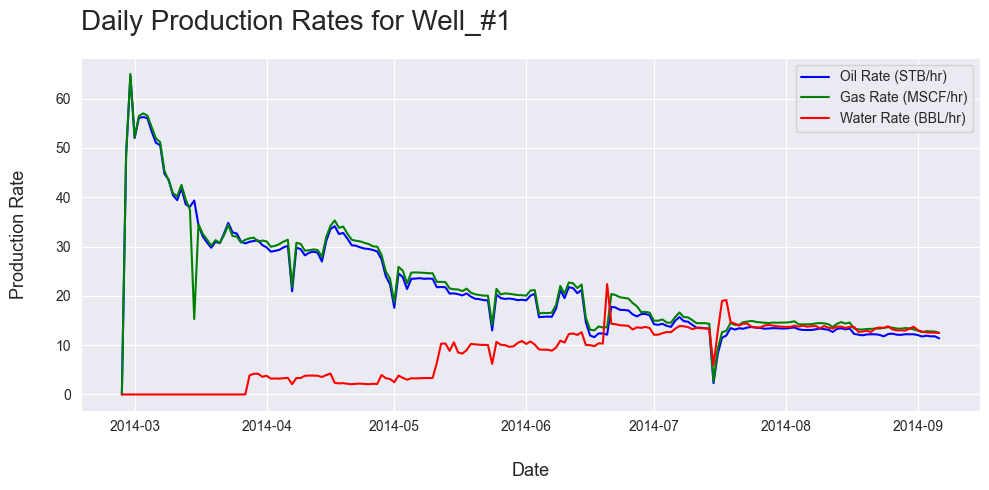

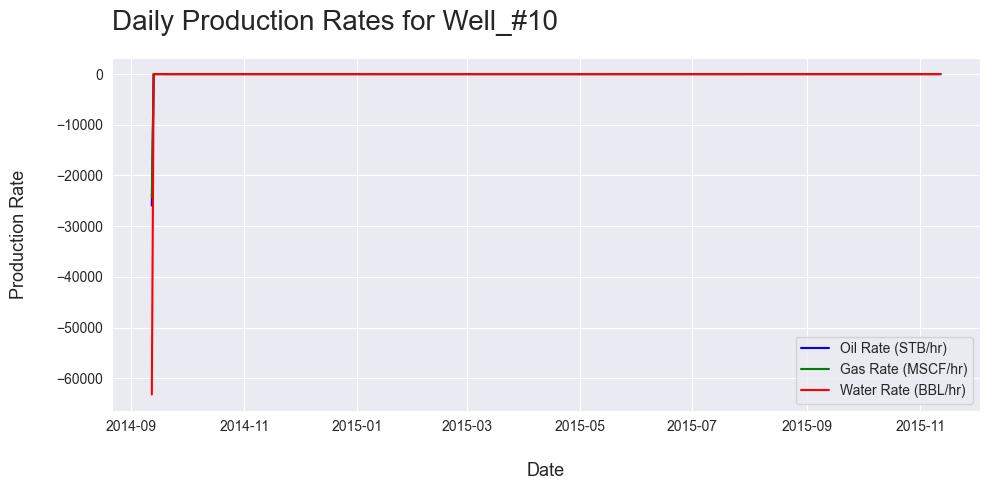

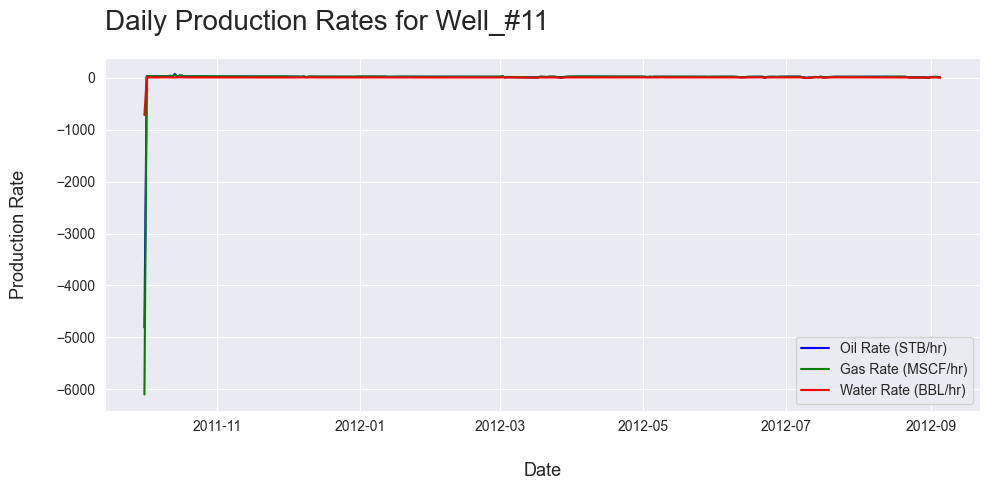

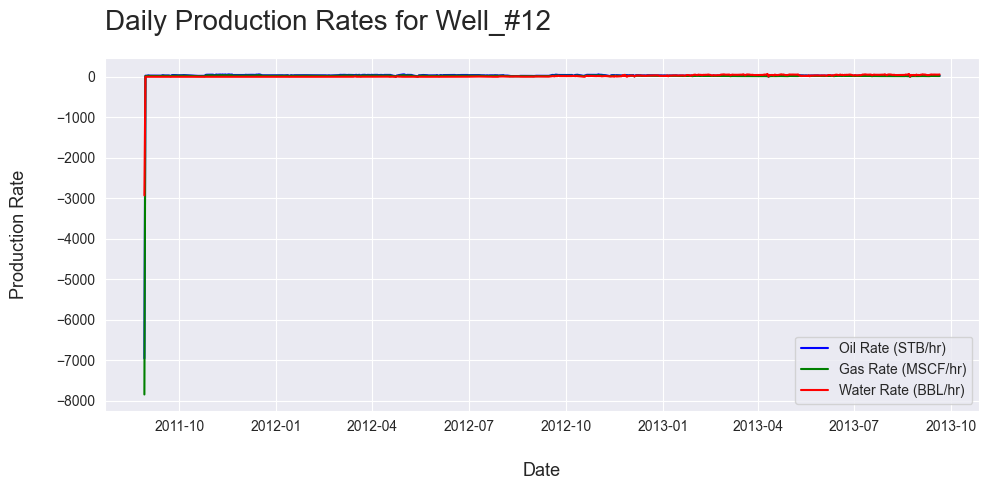

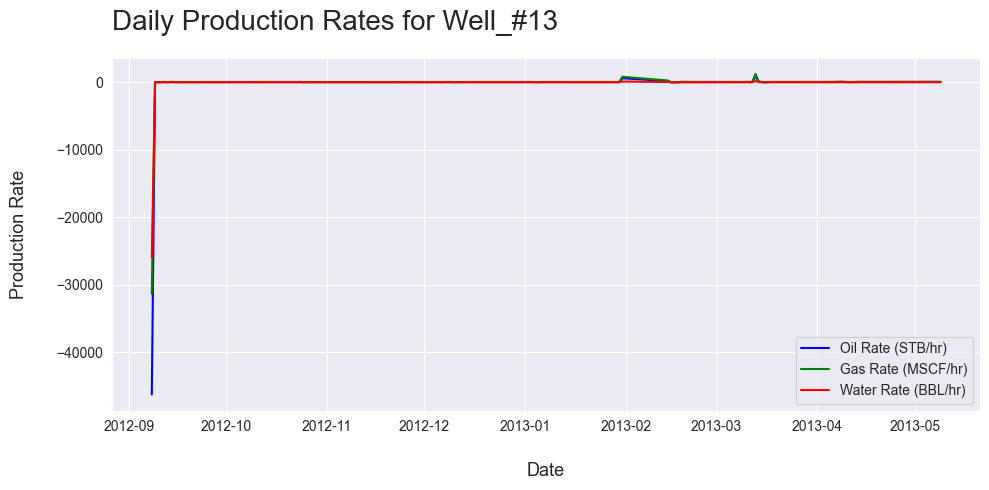

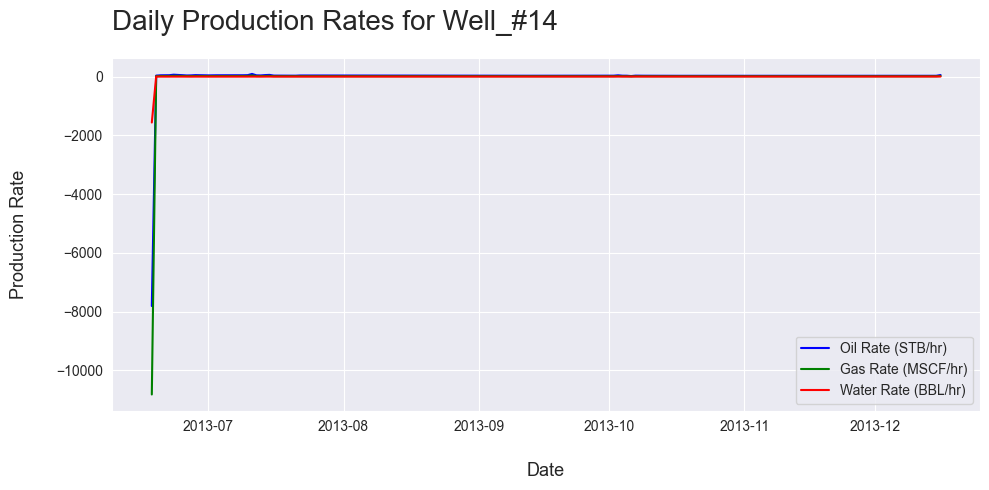

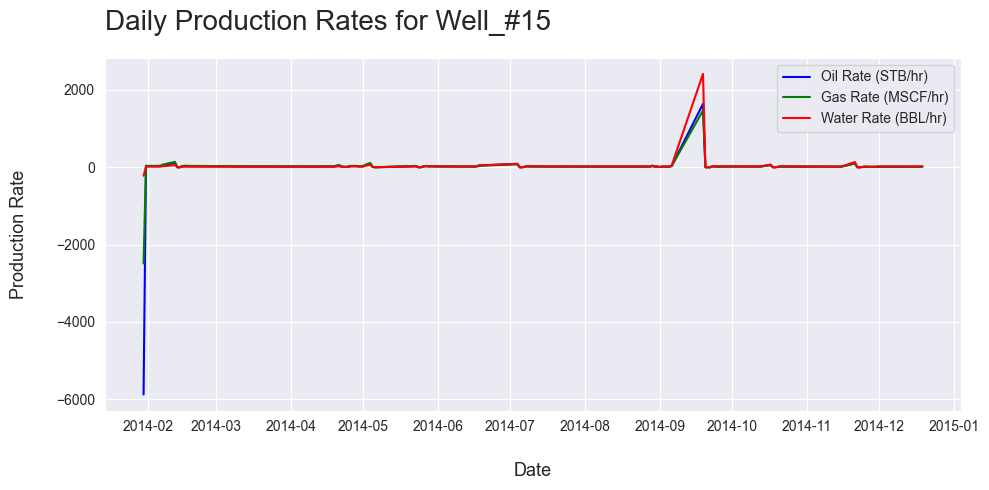

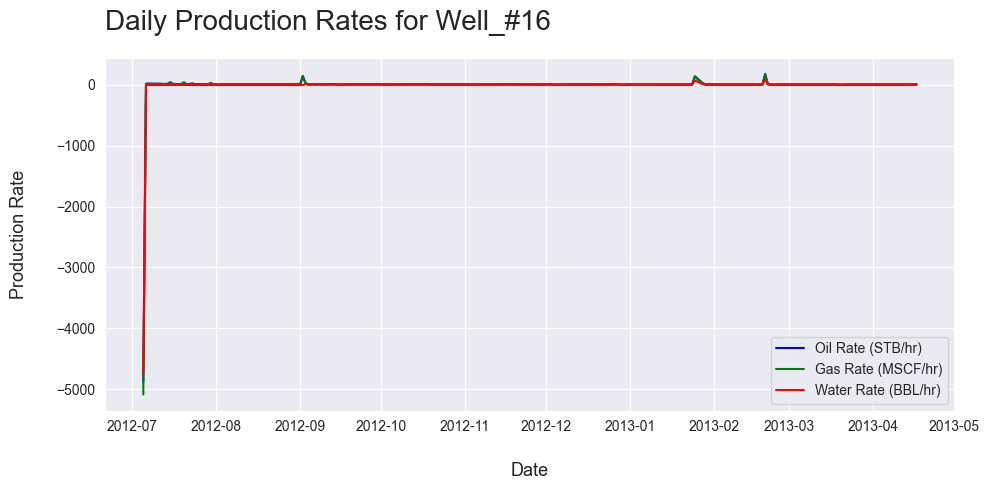

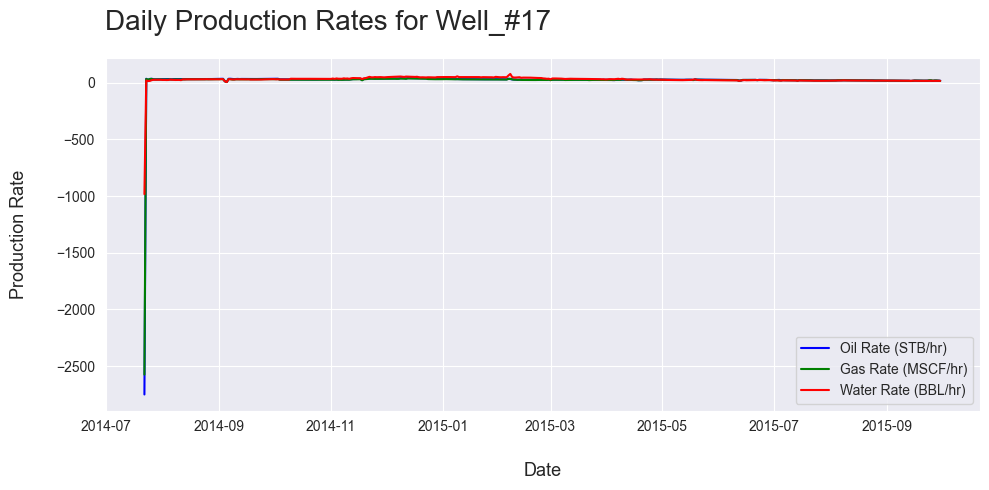

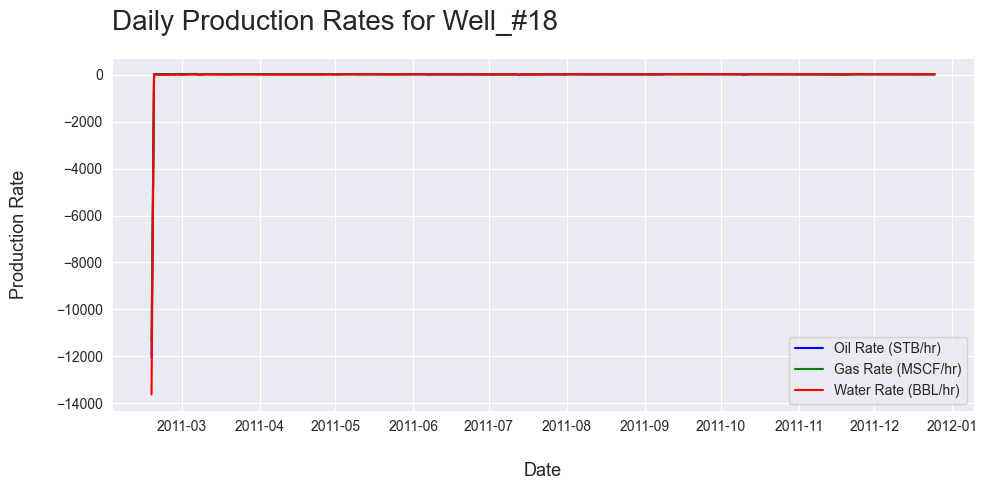

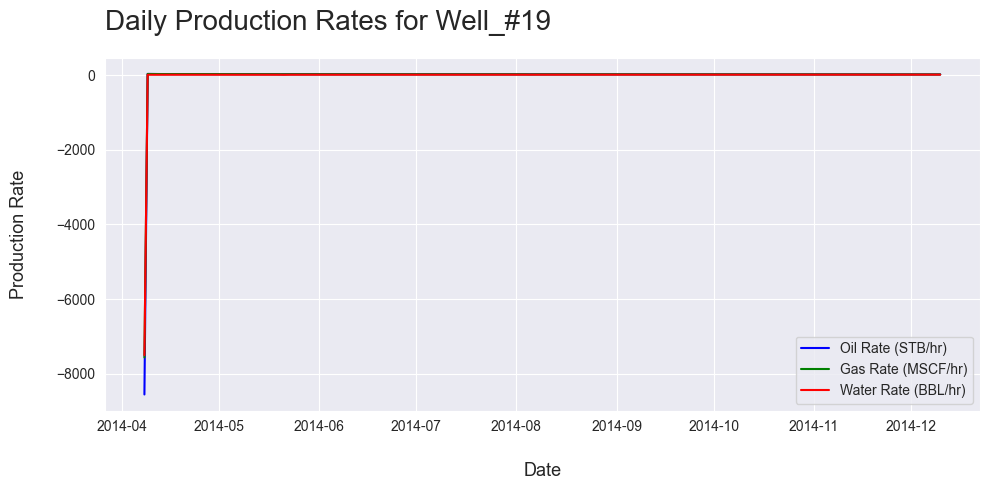

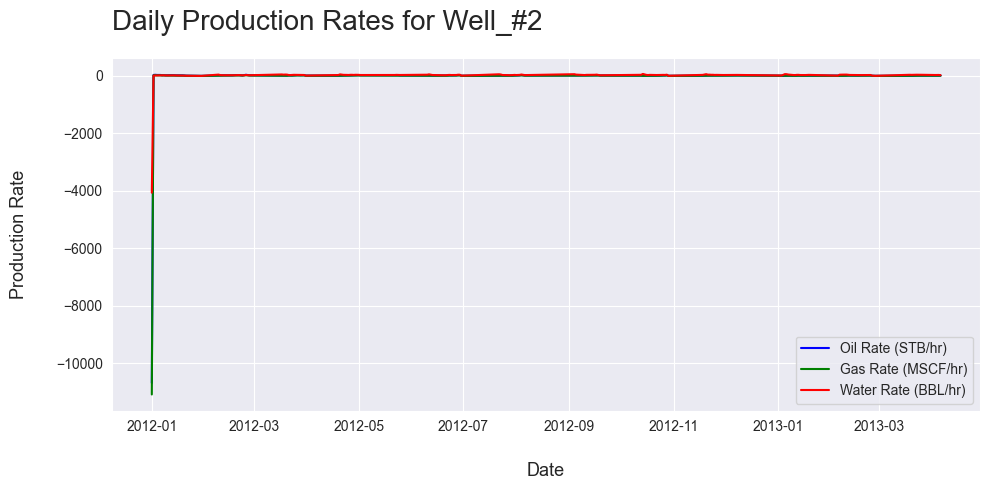

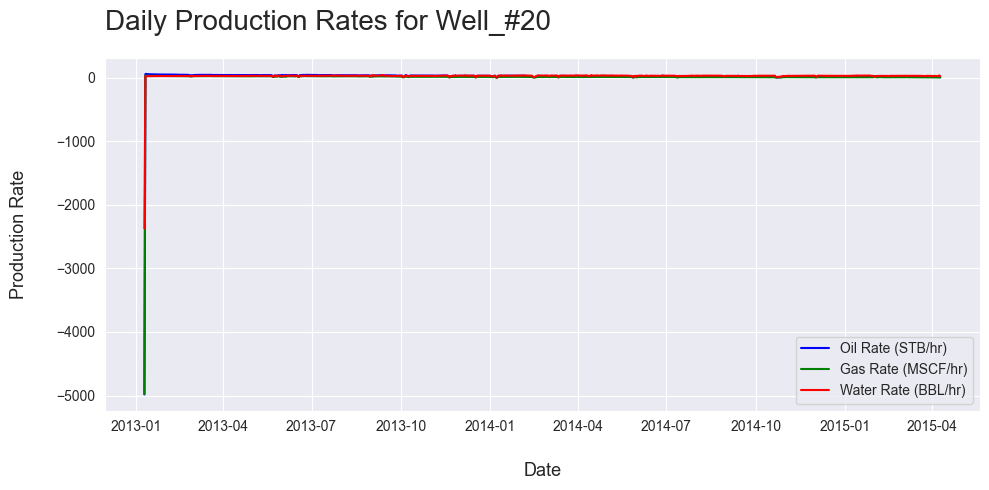

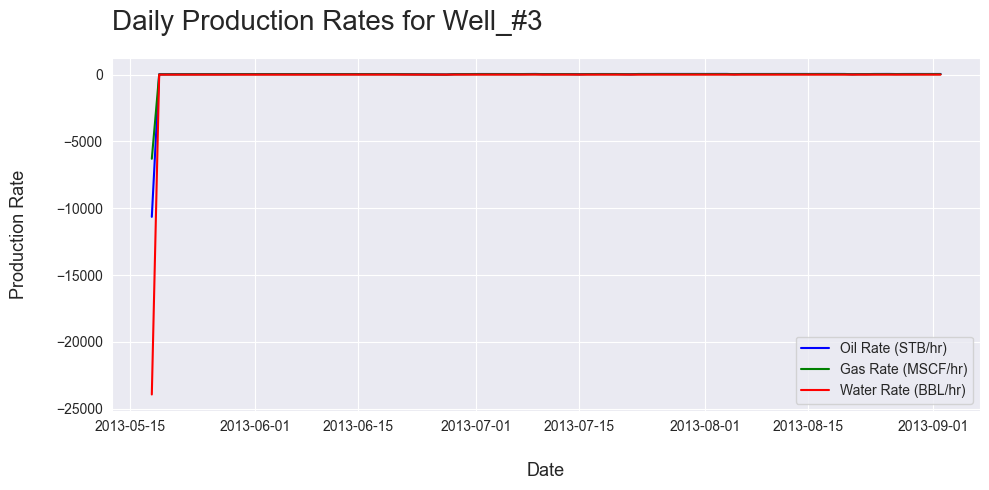

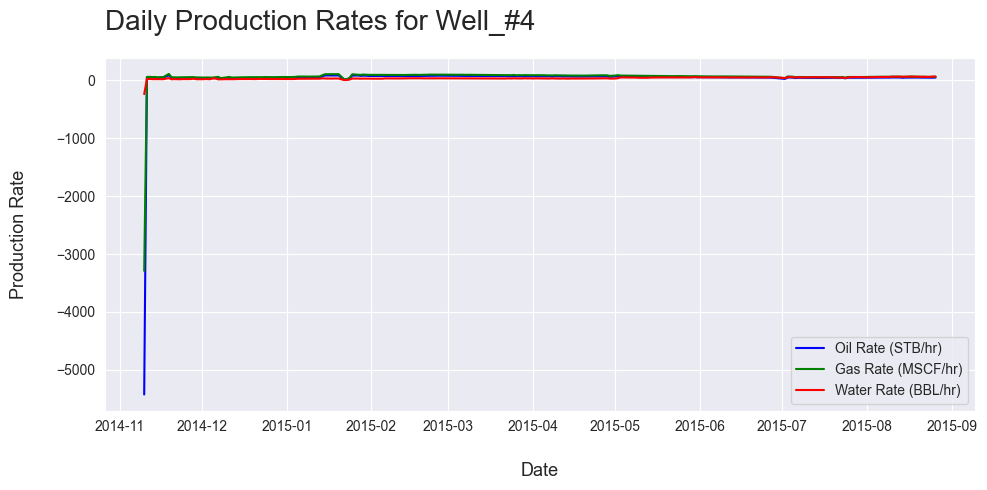

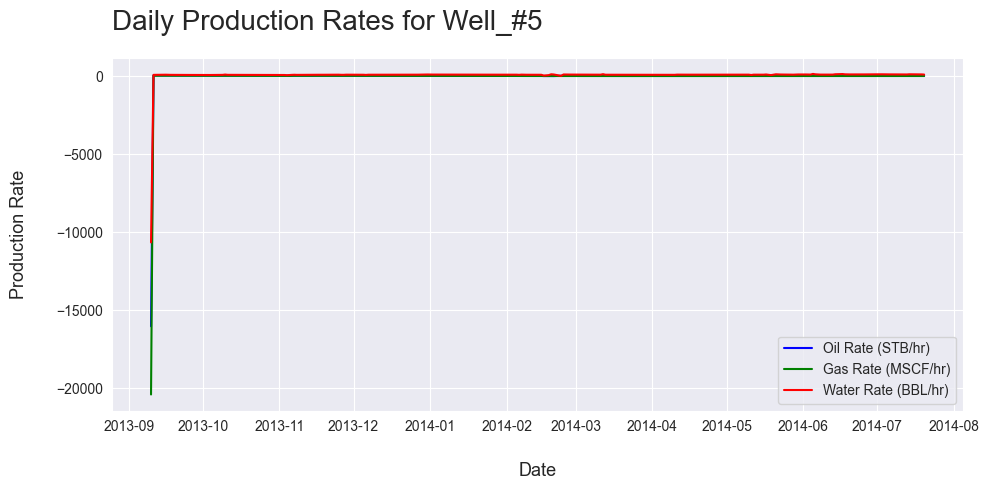

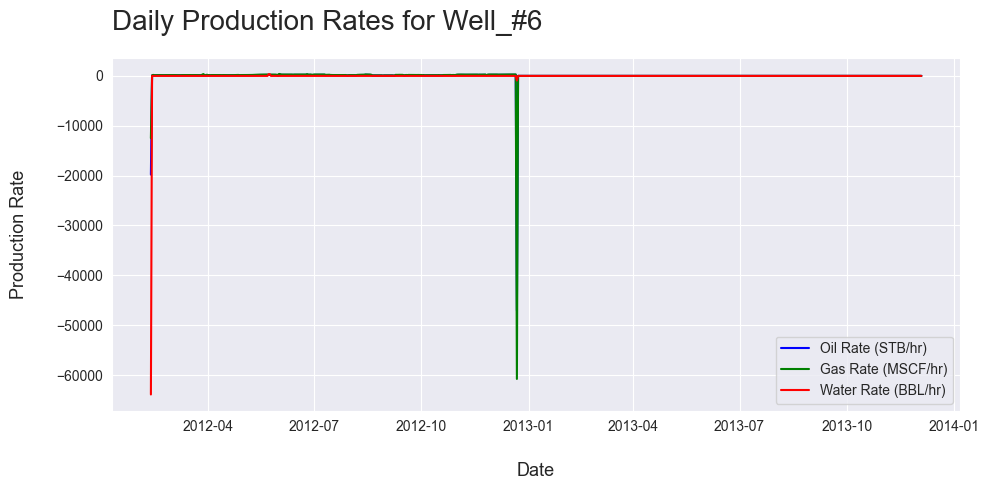

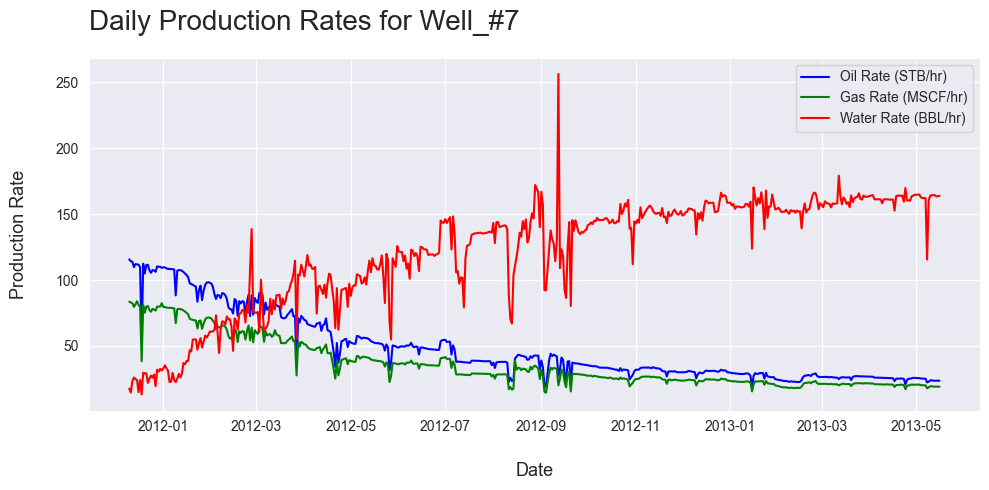

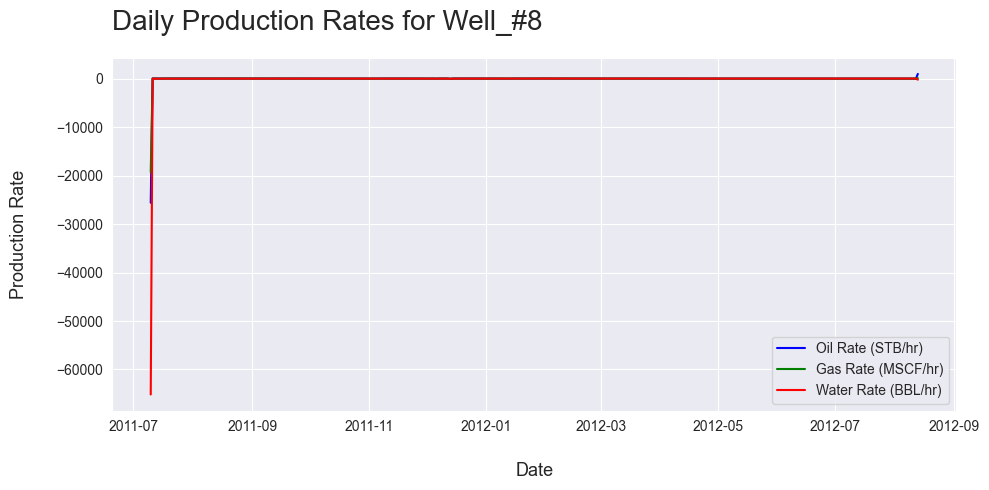

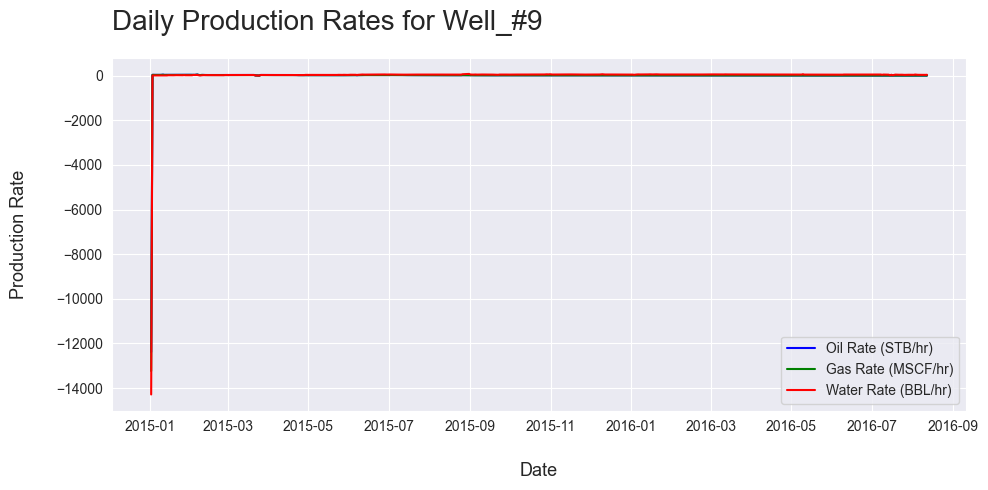

In [21]:
# Plotting oil, gas, and water production rates for each well
# Get unique well names and sort in ascending order
unique_wells = sorted(well_df['WELL_NAME'].unique())

# Process each well
for well_name in unique_wells:
    # Filter data for the current well
    well_data = well_df[well_df['WELL_NAME'] == well_name]

    # Plotting daily production rates
    plt.figure(figsize=(10, 5))
    plt.plot(well_data['PROD_DATE'], well_data['OIL_RATE'], label='Oil Rate (STB/hr)', color='blue')
    plt.plot(well_data['PROD_DATE'], well_data['GAS_RATE'], label='Gas Rate (MSCF/hr)', color='green')
    plt.plot(well_data['PROD_DATE'], well_data['WATER_RATE'], label='Water Rate (BBL/hr)', color='red')
    plt.xlabel("Date", fontsize=13, labelpad=20)
    plt.ylabel("Production Rate", fontsize=13, labelpad=20)
    plt.title(f"Daily Production Rates for {well_name}", fontsize=20, pad=20, loc="left")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'daily_production_{well_name.replace("#", "_")}.png', dpi=300)
    plt.show()

In [22]:
#group of the dataset by the well data name
Well = well_df.groupby(["WELL_NAME"]).agg({"CUMULATIVE_OIL_PROD (STB)": 'sum',
                                    'CUMULATIVE_FORMATION_GAS_PROD (MSCF)':"sum",'CUMULATIVE_WATER_PROD (BBL)':["sum","count"]})
Well = Well.reset_index()
Well

WELL_NAME CUMULATIVE_OIL_PROD (STB) CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
                                   sum                                  sum   
0    Well_#1                12306038.0                           12568315.0   
1   Well_#10                21274447.0                           26864765.0   
2   Well_#11                29051000.0                           32698776.0   
3   Well_#12               216678895.0                          147471426.0   
4   Well_#13                19906093.0                           27161041.0   
5   Well_#14                14094199.0                            5999464.0   
6   Well_#15                17539450.0                           19706147.0   
7   Well_#16                10597741.0                            9848992.0   
8   Well_#17                67027528.0                           62142165.0   
9   Well_#18                33094182.0                           29127640.0   
10  Well_#19                16148388.0                           15936388.0   
11   Well_#2                10007454.0                            5842842.0   
12  Well_#20               245971404.0                          122066079.0   
13   Well_#3                 4620498.0                            2824005.0   
14   Well_#4                55764857.0                           70536545.0   
15   Well_#5                43061873.0                           26931507.0   
16   Well_#6               161005963.0                          210057656.0   
17   Well_#7               196402706.0                          145447138.0   
18   Well_#8                55682171.0                           58544284.0   
19   Well_#9                92401196.0                           85631880.0   

   CUMULATIVE_WATER_PROD (BBL)        
                           sum count  
0                    2462698.0   193  
1                    3405784.0   402  
2                   11276499.0   319  
3                   49078449.0   699  
4                    3979903.0   231  
5                     459563.0   182  
6                   13943479.0   270  
7                    2895474.0   285  
8                   76415856.0   436  
9                   22604258.0   303  
10                   6783823.0   247  
11                  17875184.0   231  
12                 209141676.0   806  
13                    176008.0    95  
14                  29884747.0   285  
15                 108979084.0   311  
16                   3947689.0   635  
17                 322217917.0   523  
18                  54594829.0   342  
19                 158803526.0   582

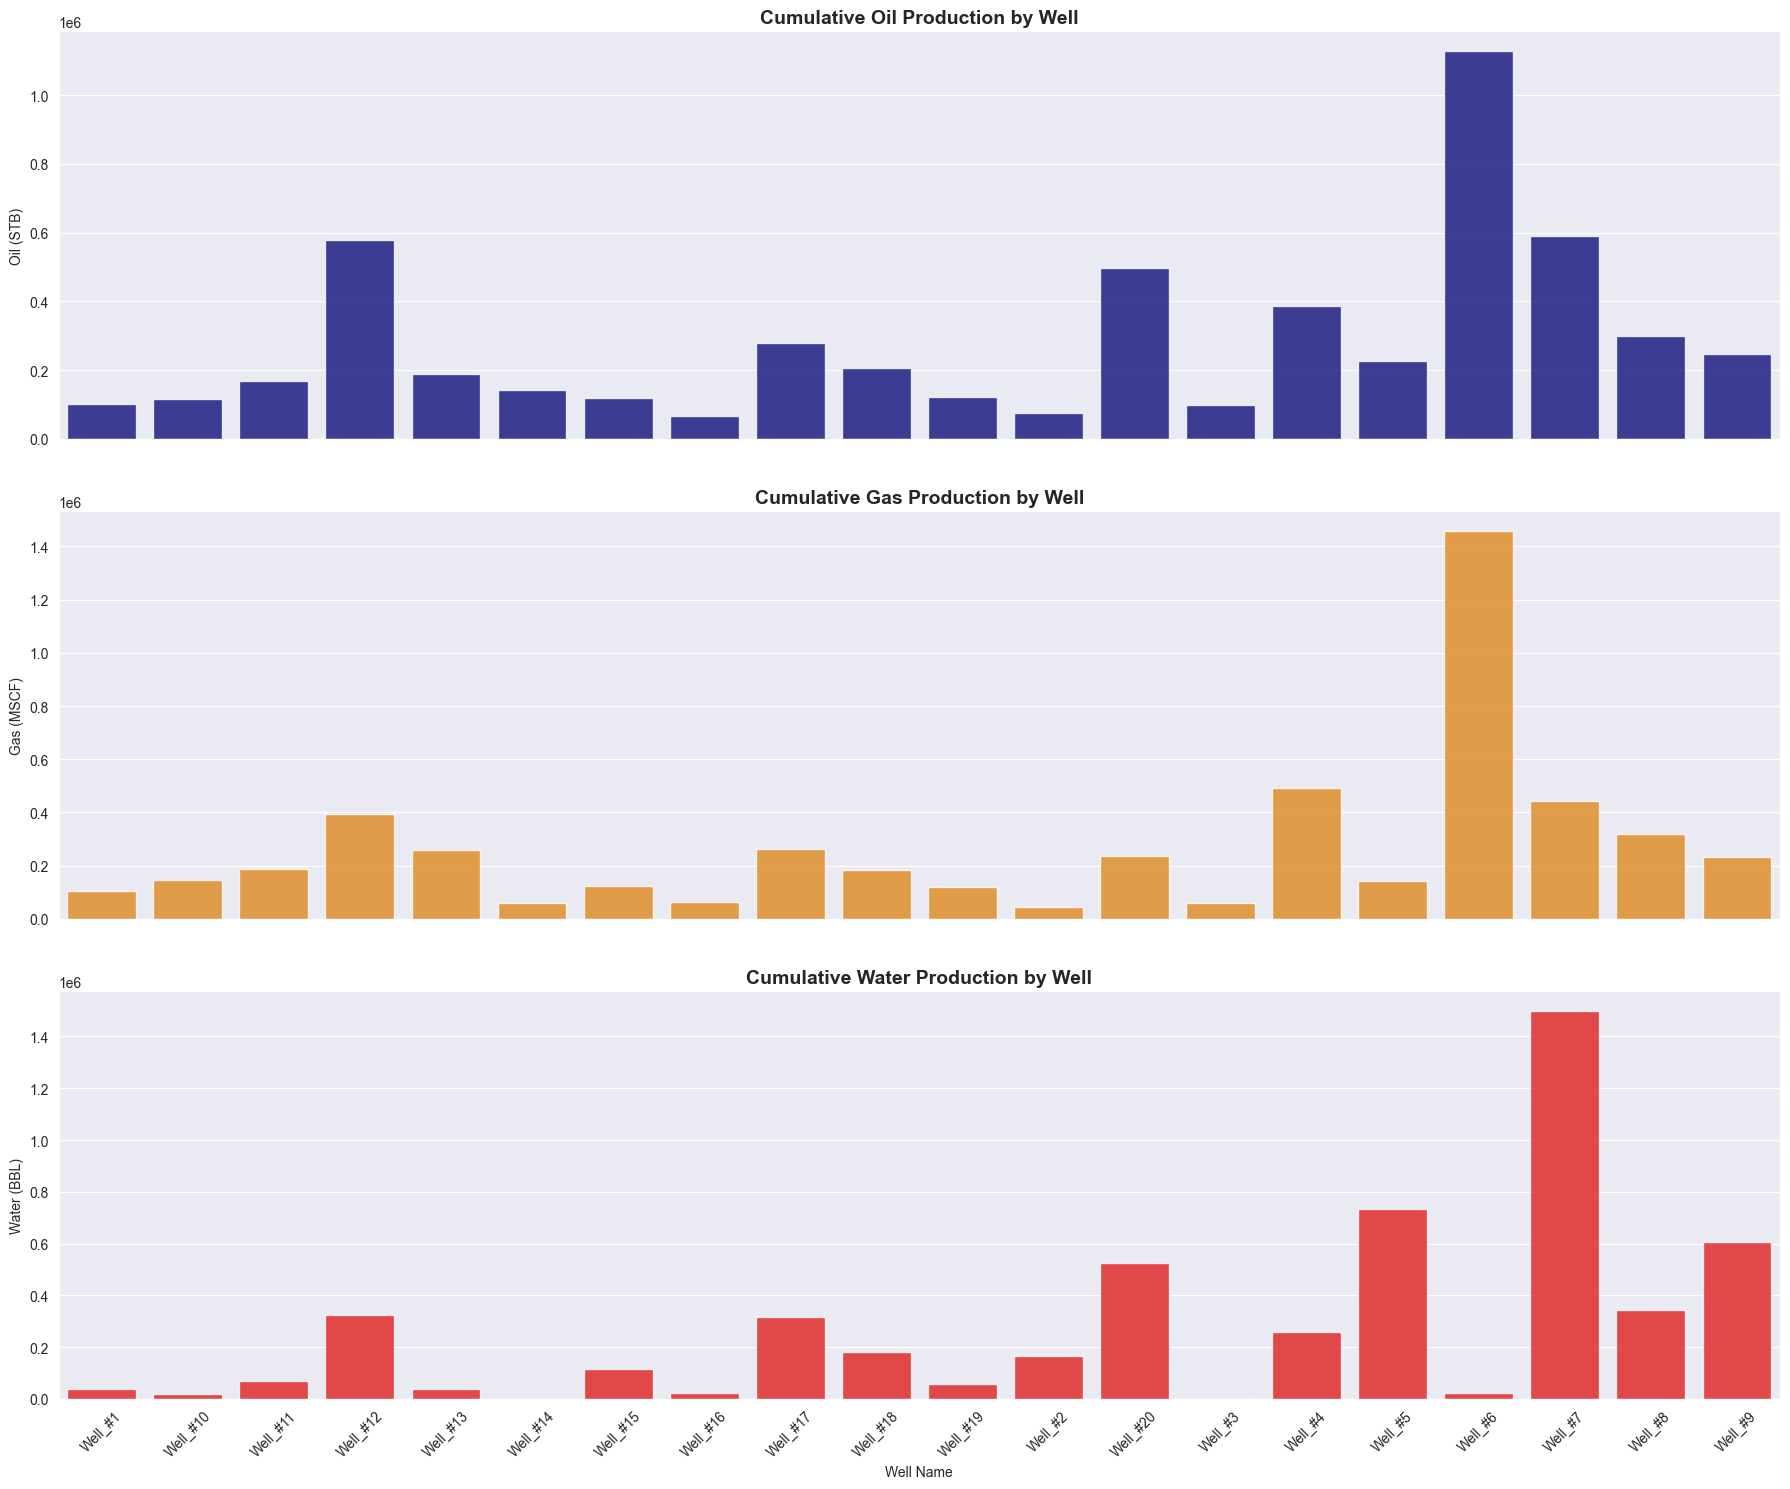

In [23]:
# Group and aggregate cumulative production by WELL_NAME
production_summary = well_df.groupby('WELL_NAME').agg({
    'CUMULATIVE_OIL_PROD (STB)': 'max',
    'CUMULATIVE_FORMATION_GAS_PROD (MSCF)': 'max',
    'CUMULATIVE_WATER_PROD (BBL)': 'max'
}).reset_index()

# Rename columns for better readability
production_summary.columns = ['WELL_NAME', 'Oil_Production', 'Gas_Production', 'Water_Production']

# Create subplots with 3 rows, 1 column (stacked vertically)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 15), sharex=True)

# Plot Oil Production
sns.barplot(ax=axes[0], x='WELL_NAME', y='Oil_Production', data=production_summary,
            color='darkblue', alpha=0.8)
axes[0].set_title('Cumulative Oil Production by Well', fontsize=14, weight='bold')
axes[0].set_ylabel('Oil (STB)')
axes[0].tick_params(axis='x', rotation=45)

# Plot Gas Production
sns.barplot(ax=axes[1], x='WELL_NAME', y='Gas_Production', data=production_summary,
            color='darkorange', alpha=0.8)
axes[1].set_title('Cumulative Gas Production by Well', fontsize=14, weight='bold')
axes[1].set_ylabel('Gas (MSCF)')
axes[1].tick_params(axis='x', rotation=45)

# Plot Water Production
sns.barplot(ax=axes[2], x='WELL_NAME', y='Water_Production', data=production_summary,
            color='red', alpha=0.8)
axes[2].set_title('Cumulative Water Production by Well', fontsize=14, weight='bold')
axes[2].set_ylabel('Water (BBL)')
axes[2].set_xlabel('Well Name')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(h_pad=3)
plt.show()

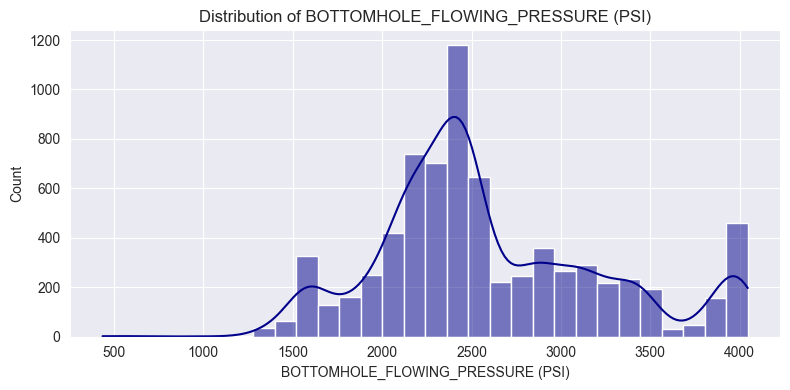

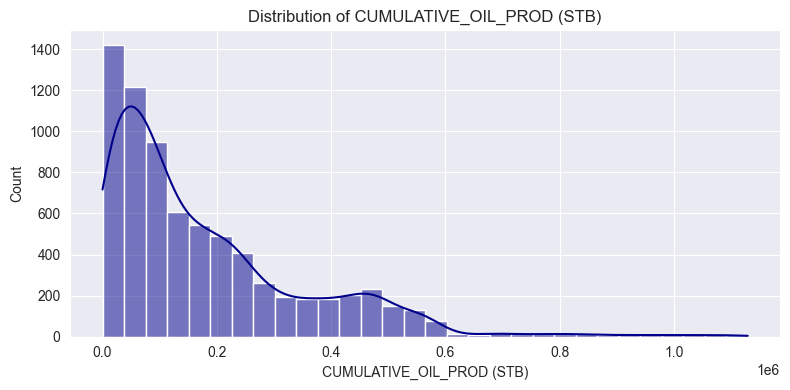

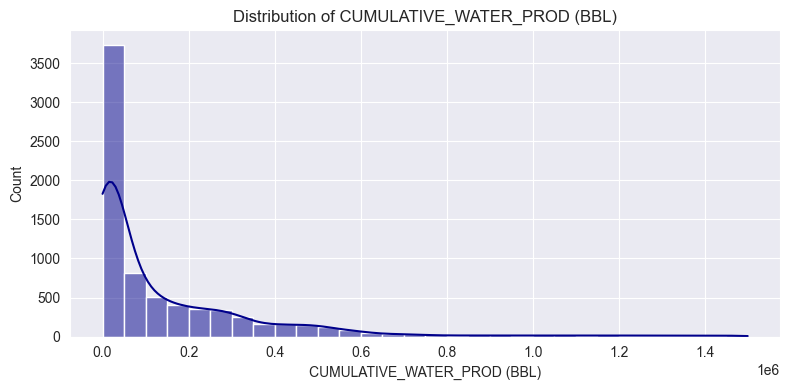

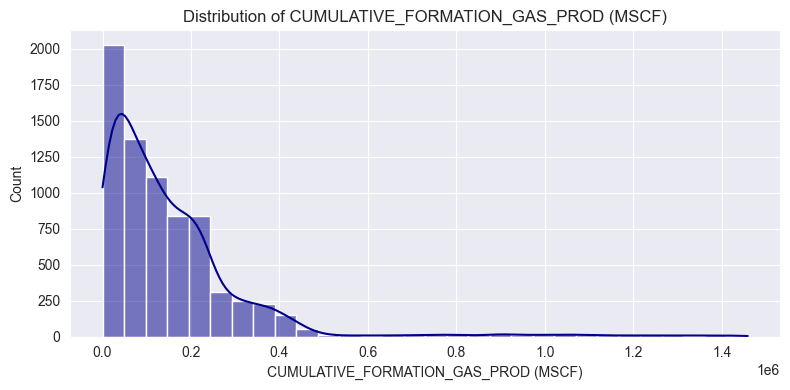

In [24]:
bhp_data = well_df[well_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] > 0]  # Filter out invalid pressures
# Distibution plots
num_cols = ['BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'CUMULATIVE_OIL_PROD (STB)',
            'CUMULATIVE_WATER_PROD (BBL)', 'CUMULATIVE_FORMATION_GAS_PROD (MSCF)']
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(well_df[col].dropna(), bins=30, kde=True, color='darkblue')  # Apply darkblue to all histograms
    plt.title(f'Distribution of {col}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Pressure Data Distribution and Outlier Analysis

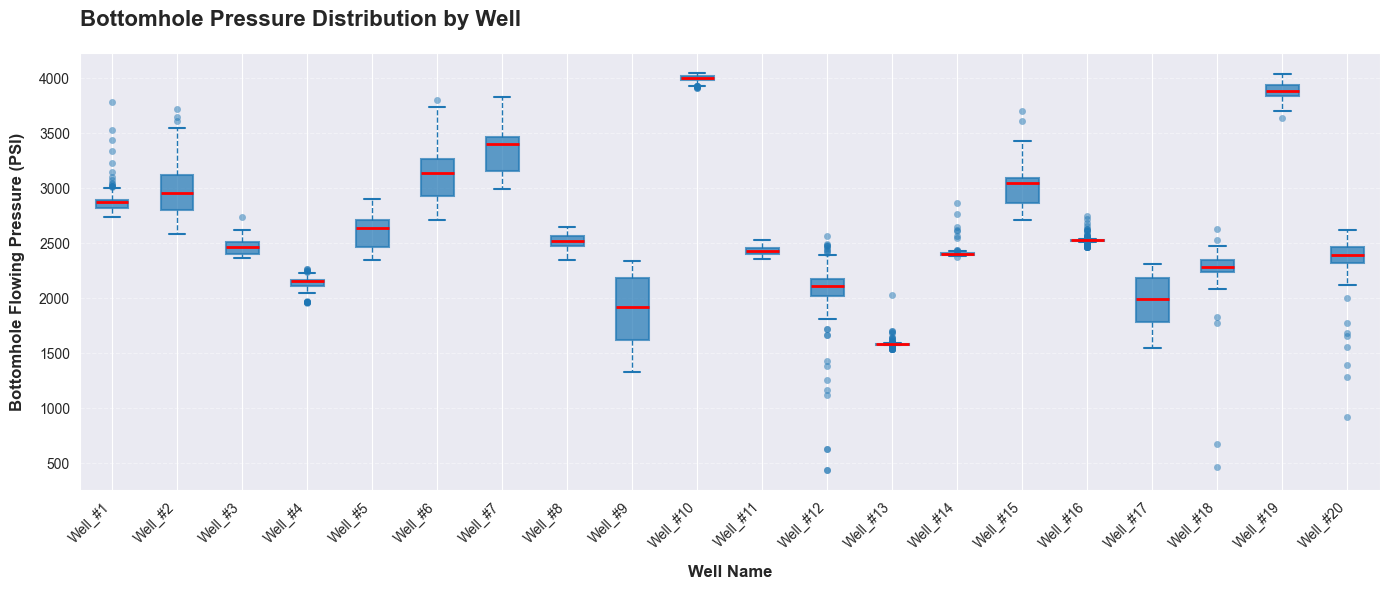

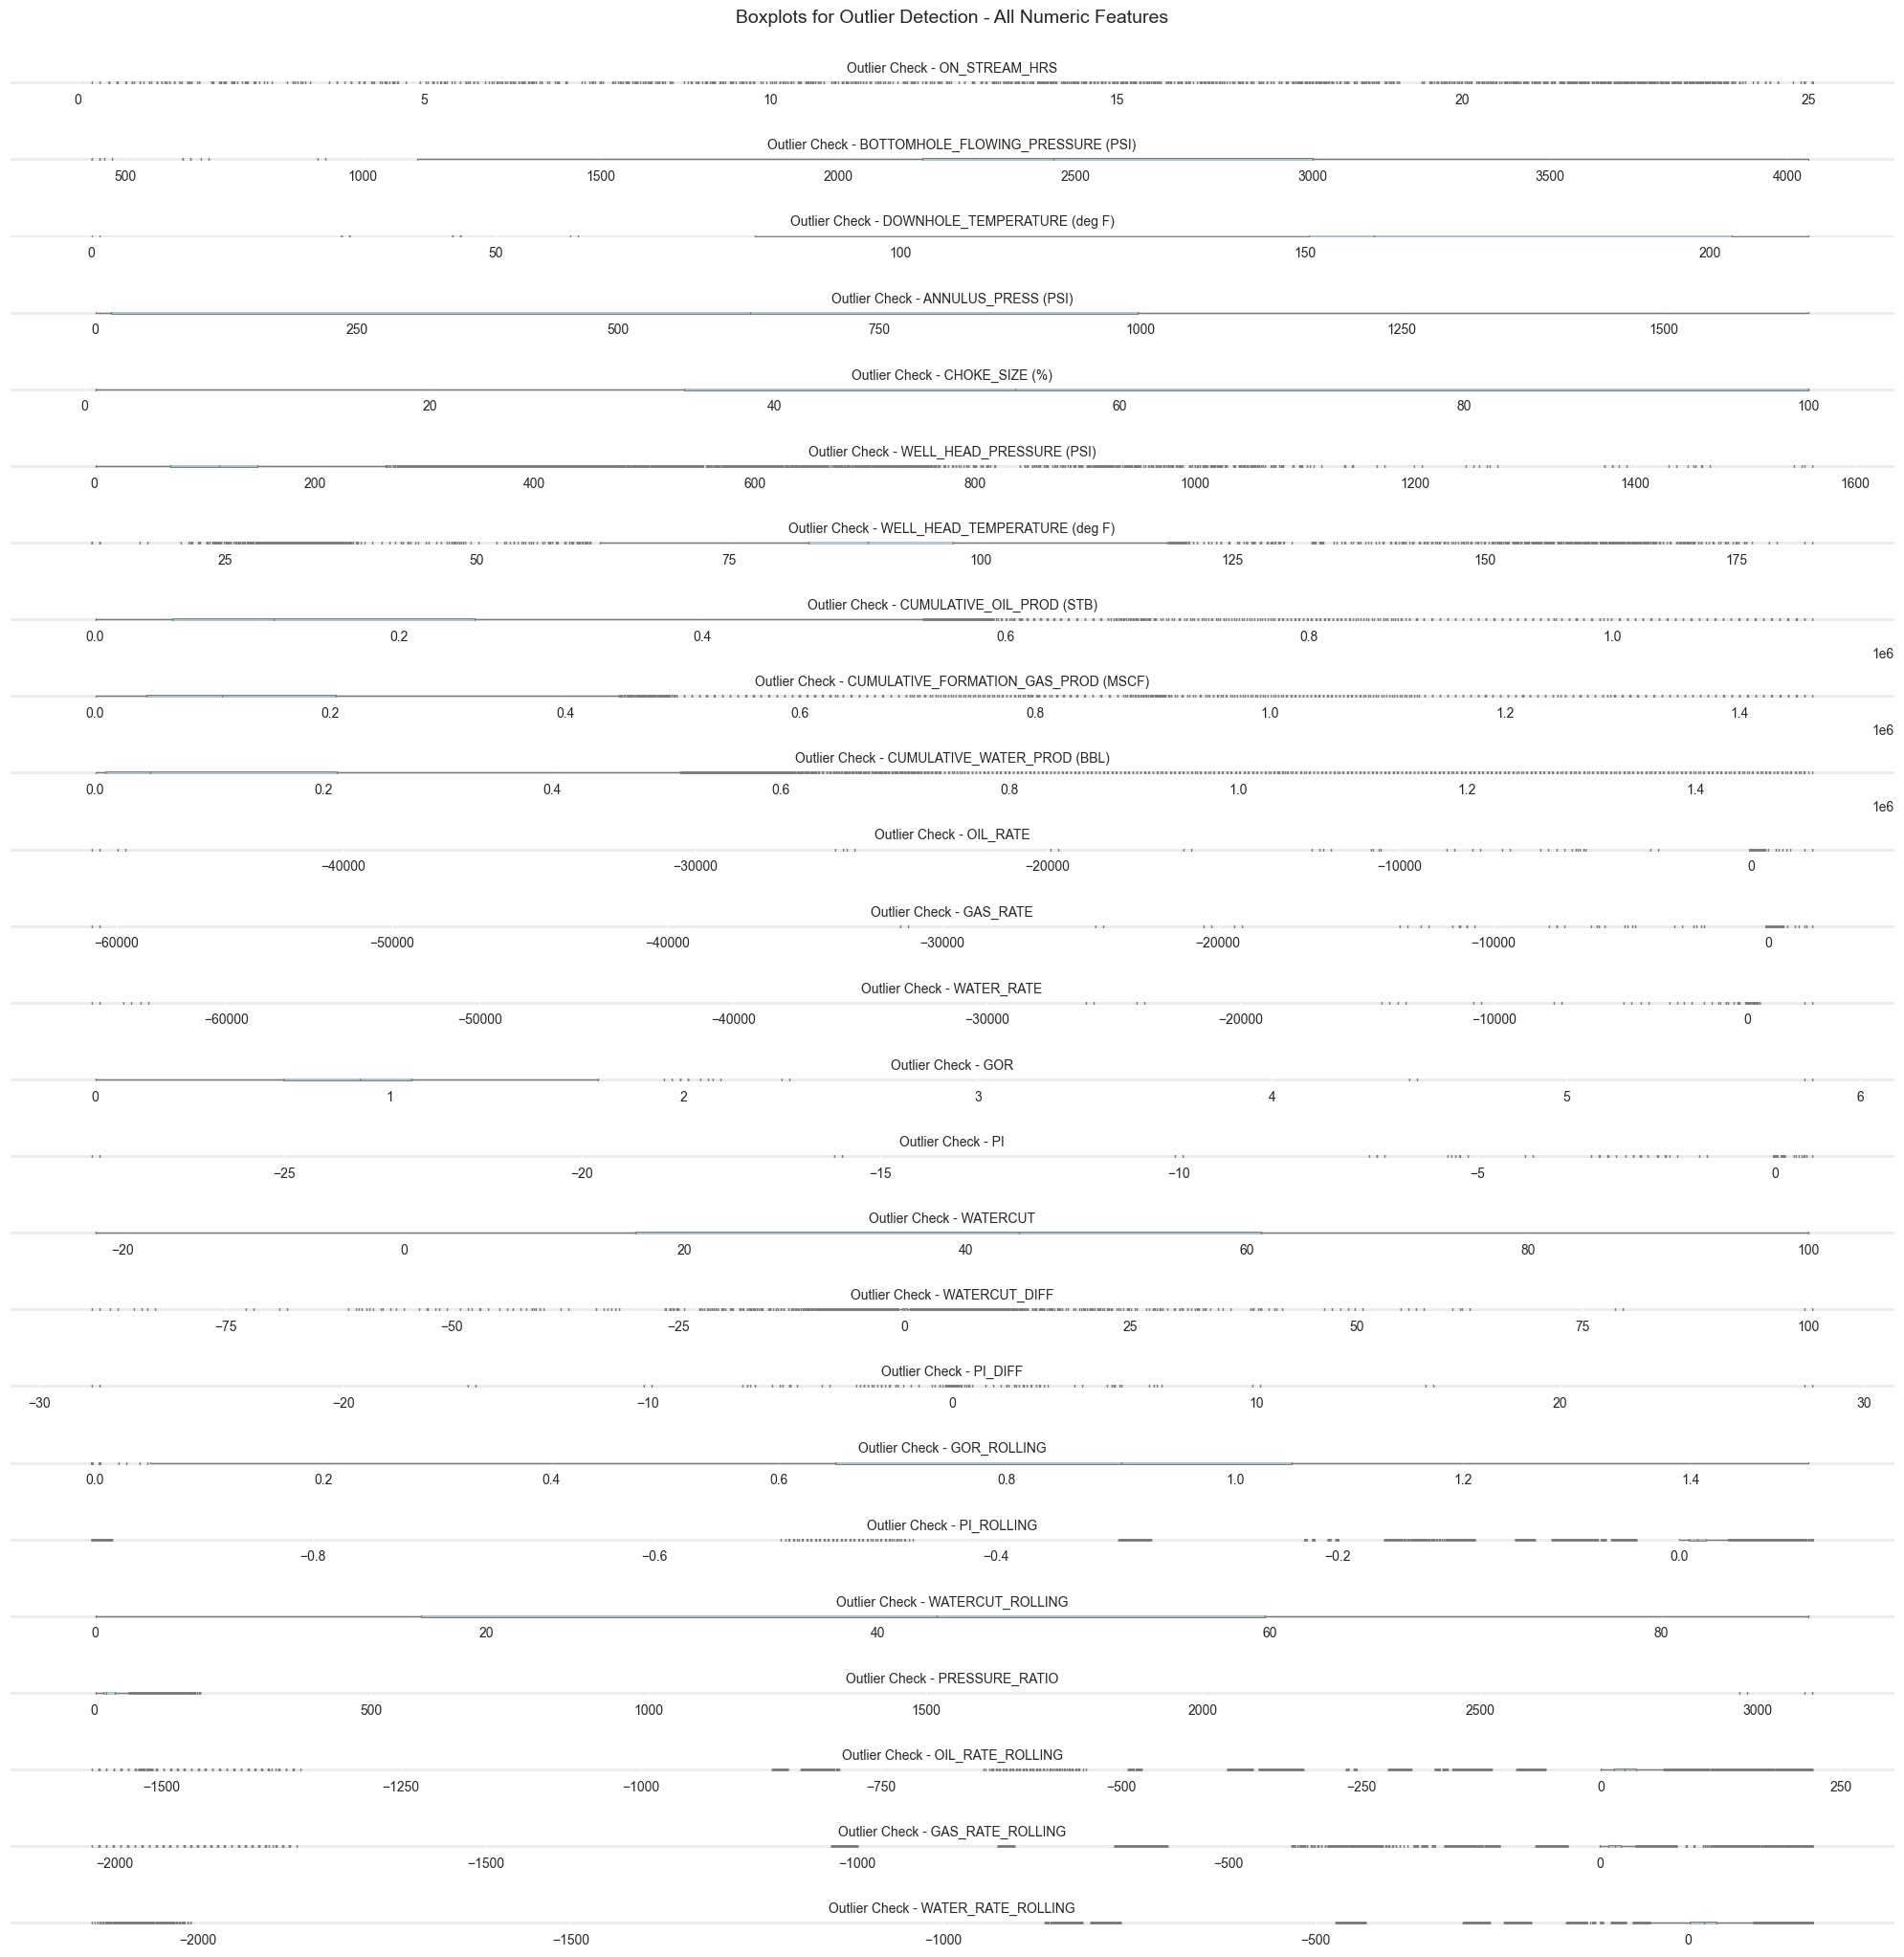

In [25]:
# Subplot 2: BHP Distribution per Well (Box Plot)
plt.figure(figsize=(14, 6))

# Prepare data
well_names = bhp_data['WELL_NAME'].unique()
bhp_per_well = [bhp_data[bhp_data['WELL_NAME'] == well]['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].dropna() 
                for well in well_names]

# Create boxplot with refined styling
boxplot = plt.boxplot(bhp_per_well, 
                      labels=well_names, 
                      patch_artist=True,
                      boxprops=dict(facecolor='#1f77b4', alpha=0.7, edgecolor='#1f77b4', linewidth=1.5),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(color='#1f77b4', linestyle='--', linewidth=1),
                      capprops=dict(color='#1f77b4', linewidth=1.5),
                      flierprops=dict(marker='o', markersize=5, markerfacecolor='#1f77b4', alpha=0.5, markeredgecolor='none'))

# Customize plot appearance
plt.xlabel("Well Name", fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel("Bottomhole Flowing Pressure (PSI)", fontsize=12, fontweight='bold', labelpad=10)
plt.title("Bottomhole Pressure Distribution by Well", fontsize=16, fontweight='bold', pad=20, loc='left')

# Rotate x-axis labels and adjust alignment
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add light grid and adjust spines
plt.grid(axis='y', linestyle='--', alpha=0.4)
# Adjust layout and save
plt.tight_layout()
plt.savefig('bhp_distribution_plot.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()


# Select only numeric columns
numeric_cols = well_df.select_dtypes(include=['float64', 'int64']).columns

# Plot boxplots for all numeric features
plt.figure(figsize=(20, len(numeric_cols) * 0.8))  # Adjust height dynamically
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=well_df[col], color='lightblue')
    plt.title(f'Outlier Check - {col}', fontsize=10)
    plt.xlabel('')
    plt.tight_layout()

plt.suptitle('Boxplots for Outlier Detection - All Numeric Features', fontsize=14, y=1.02)
plt.savefig('bhp_distribution_outlier_detectionplot.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()


Preserving data integrity is critical as outliers may reflect real well conditions, and since most are not errors, the Random Forest model is robust enough to handle them without affecting classification accuracy.

In order to get accurate result in the classification, I made a two copy of the data. One with minimal cleaning and processing for the classification and the other copy for exploration and visualization. I did this with the observation that during some rigorous cleaning the integrity of the dataset were lost leading to inaccurate classification and thereby causing less accurate model.

In [26]:
well_df = well_df_raw.copy()
classification_df = well_df_raw.copy()

In [27]:
well2 = well_df_raw[classification_df["WELL_NAME"] == "Well_#2"]

In [28]:
well2.describe()

PROD_DATE  ON_STREAM_HRS  BOTTOMHOLE_FLOWING_PRESSURE (PSI)  \
count                  477     477.000000                         477.000000   
mean   2012-08-26 00:00:00      10.814130                        3164.121593   
min    2012-01-01 00:00:00       0.000000                        2582.000000   
25%    2012-04-29 00:00:00       0.000000                        2905.000000   
50%    2012-08-26 00:00:00       0.000000                        3132.000000   
75%    2012-12-23 00:00:00      24.000000                        3444.000000   
max    2013-04-21 00:00:00      24.000000                        3735.000000   
std                    NaN      11.666452                         311.393645   

       DOWNHOLE_TEMPERATURE (deg F)  ANNULUS_PRESS (PSI)  CHOKE_SIZE (%)  \
count                    477.000000                477.0      477.000000   
mean                     202.146285                  0.0       24.606748   
min                       29.440000                  0.0        0.000000   
25%                      196.886000                  0.0        0.000000   
50%                      201.048000                  0.0        0.755740   
75%                      208.387000                  0.0       51.694890   
max                      208.818000                  0.0       90.826370   
std                        9.693048                  0.0       26.288651   

       WELL_HEAD_PRESSURE (PSI)  WELL_HEAD_TEMPERATURE (deg F)  \
count                477.000000                     477.000000   
mean                 861.152174                      99.672191   
min                    0.000000                      32.000000   
25%                  445.424000                      50.878000   
50%                  630.322000                      63.324000   
75%                 1425.710000                     156.293000   
max                 1787.760000                     182.157000   
std                  522.680518                      51.391226   

       CUMULATIVE_OIL_PROD (STB)  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  \
count                 477.000000                            477.000000   
mean                44623.526205                          26045.645702   
min                    94.000000                             66.000000   
25%                 30266.000000                          17563.000000   
50%                 45408.000000                          26318.000000   
75%                 62235.000000                          36367.000000   
max                 74524.000000                          44092.000000   
std                 19693.889128                          11595.434029   

       CUMULATIVE_WATER_PROD (BBL)  
count                   477.000000  
mean                  78800.362683  
min                      65.000000  
25%                   39018.000000  
50%                   73523.000000  
75%                  119743.000000  
max                  167577.000000  
std                   49409.443825

In [29]:
# Preserve raw data for classification with minimal cleaning
classification_df_raw = classification_df.dropna(subset=['BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'WELL_NAME', 'PROD_DATE'])
classification_df_raw = classification_df[classification_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] > 0]

In [30]:
# Filtering out non-production rows (ON_STREAM_HRS > 0) for production rates
well_df = well_df[well_df['ON_STREAM_HRS'] > 0]

# Calculating daily production rates
well_df['OIL_RATE'] = well_df['CUMULATIVE_OIL_PROD (STB)'].diff() / well_df['ON_STREAM_HRS']
well_df['GAS_RATE'] = well_df['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].diff() / well_df['ON_STREAM_HRS']
well_df['WATER_RATE'] = well_df['CUMULATIVE_WATER_PROD (BBL)'].diff() / well_df['ON_STREAM_HRS']

# Dropping rows with NaN values from diff() and handling negative rates (anomalies)
well_df = well_df.dropna()
well_df = well_df[(well_df['OIL_RATE'] >= 0) & (well_df['GAS_RATE'] >= 0) & (well_df['WATER_RATE'] >= 0)]

In [31]:
# Checking for missing values
print("Missing Values After Preprocessin Well_df:", well_df.isna().sum())
print("Missing Values After Preprocessing Classification_df:", classification_df.isna().sum())

Missing Values After Preprocessin Well_df: PROD_DATE                               0
WELL_NAME                               0
ON_STREAM_HRS                           0
BOTTOMHOLE_FLOWING_PRESSURE (PSI)       0
DOWNHOLE_TEMPERATURE (deg F)            0
ANNULUS_PRESS (PSI)                     0
CHOKE_SIZE (%)                          0
WELL_HEAD_PRESSURE (PSI)                0
WELL_HEAD_TEMPERATURE (deg F)           0
CUMULATIVE_OIL_PROD (STB)               0
CUMULATIVE_FORMATION_GAS_PROD (MSCF)    0
CUMULATIVE_TOTAL_GAS_PROD (MSCF)        0
CUMULATIVE_WATER_PROD (BBL)             0
OIL_RATE                                0
GAS_RATE                                0
WATER_RATE                              0
dtype: int64
Missing Values After Preprocessing Classification_df: PROD_DATE                               0
WELL_NAME                               0
ON_STREAM_HRS                           0
BOTTOMHOLE_FLOWING_PRESSURE (PSI)       0
DOWNHOLE_TEMPERATURE (deg F)            0
ANNULUS_

In [32]:
print("\nSummary Statistics of Cleaned Data:")
print(well_df.describe())


Summary Statistics of Cleaned Data:
                           PROD_DATE  ON_STREAM_HRS  \
count                           7406    7406.000000   
mean   2013-09-11 23:26:45.076964608      23.170435   
min              2011-02-18 00:00:00       0.250000   
25%              2012-08-12 00:00:00      24.000000   
50%              2013-07-24 00:00:00      24.000000   
75%              2014-10-19 00:00:00      24.000000   
max              2016-08-12 00:00:00      25.000000   
std                              NaN       3.238433   

       BOTTOMHOLE_FLOWING_PRESSURE (PSI)  DOWNHOLE_TEMPERATURE (deg F)  \
count                        7406.000000                   7406.000000   
mean                         2581.946530                    168.394701   
min                             0.000000                      0.000000   
25%                          2174.000000                    150.258250   
50%                          2451.000000                    158.415500   
75%                    

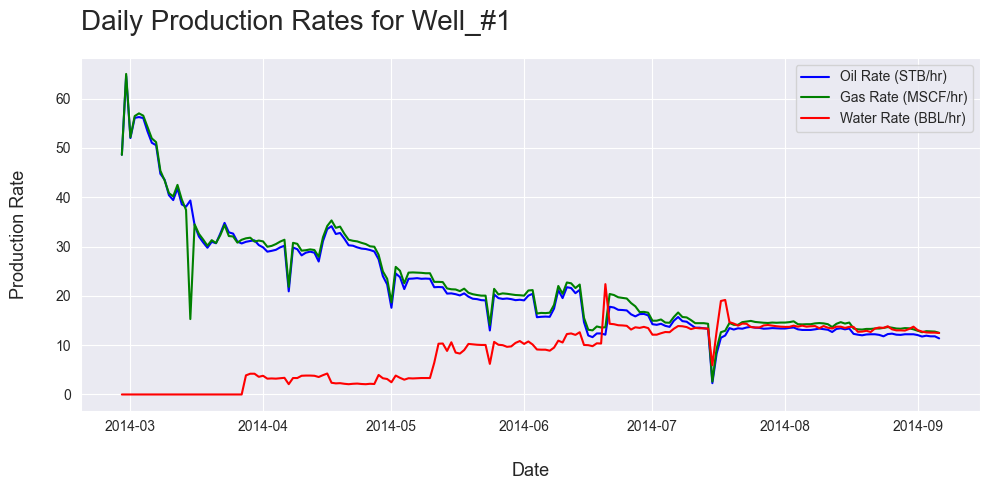

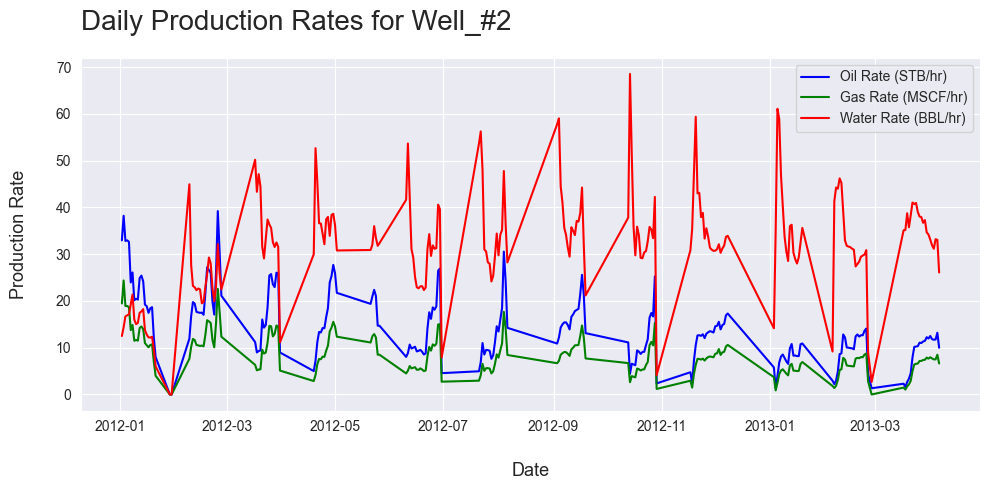

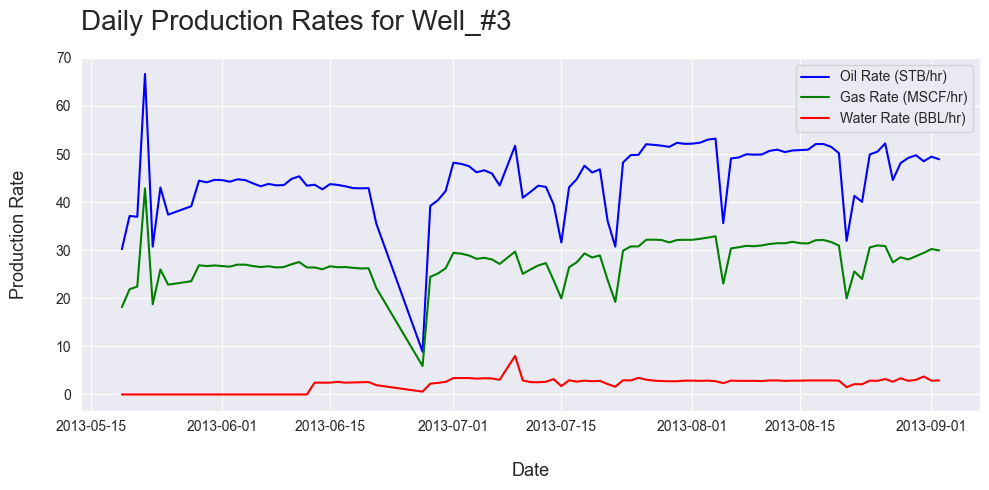

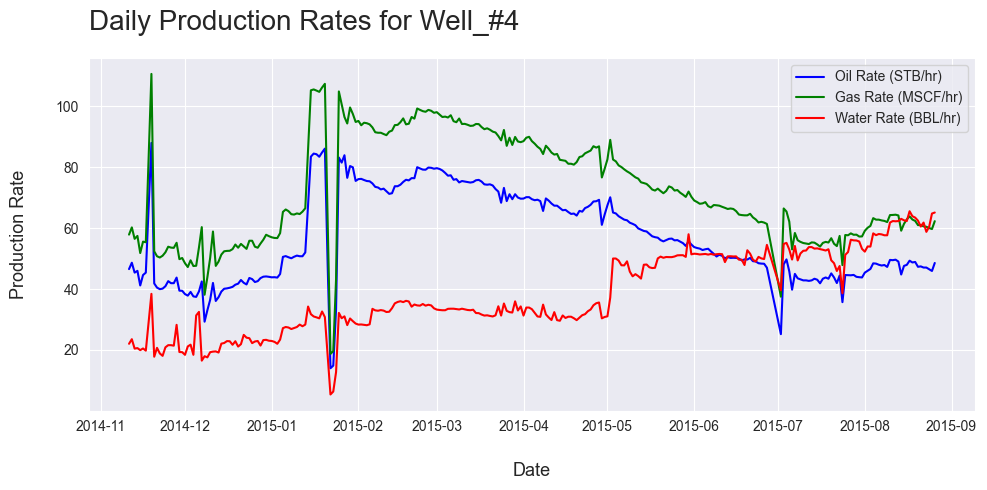

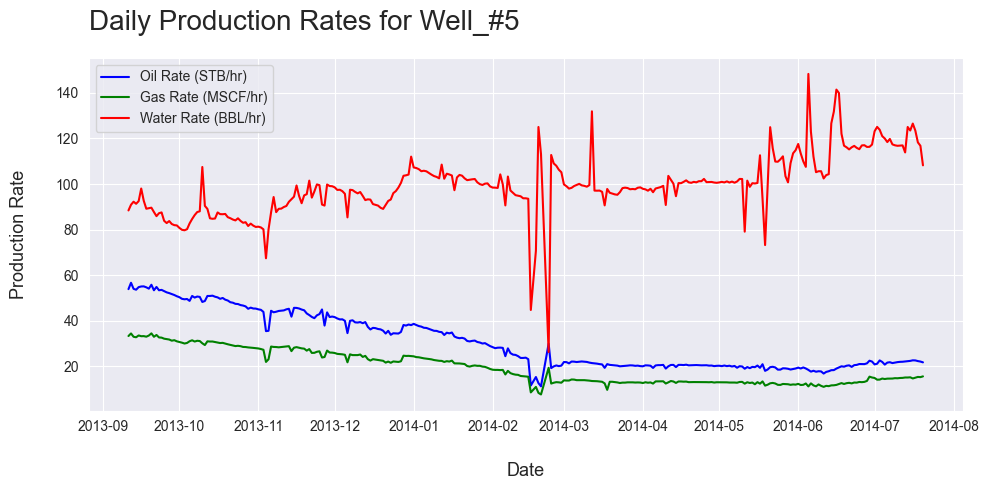

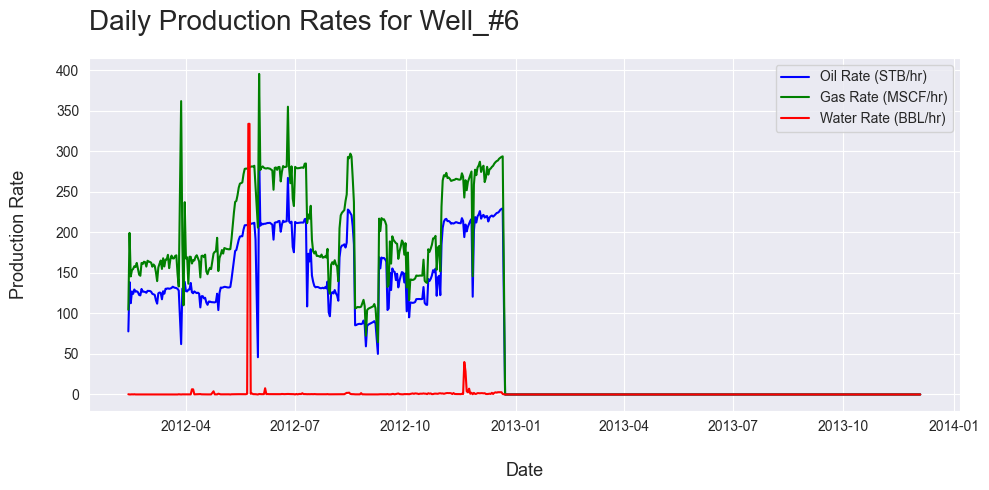

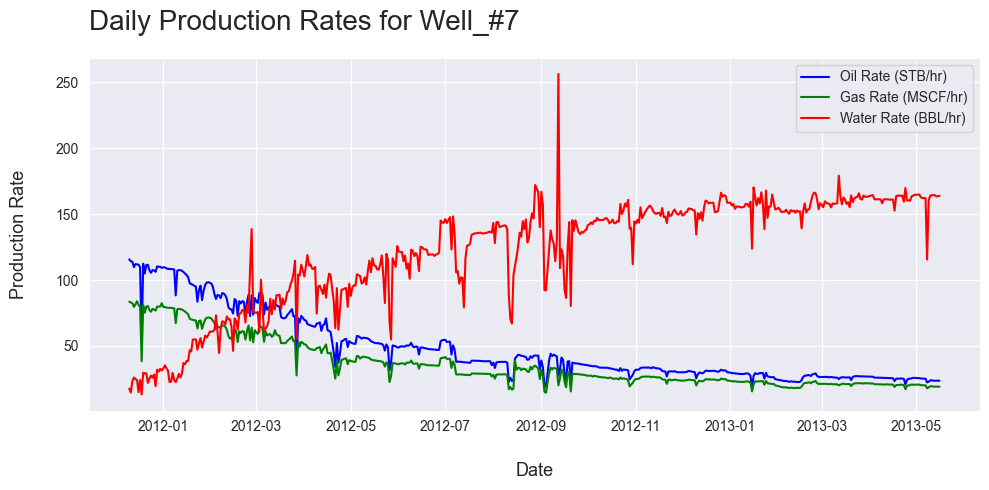

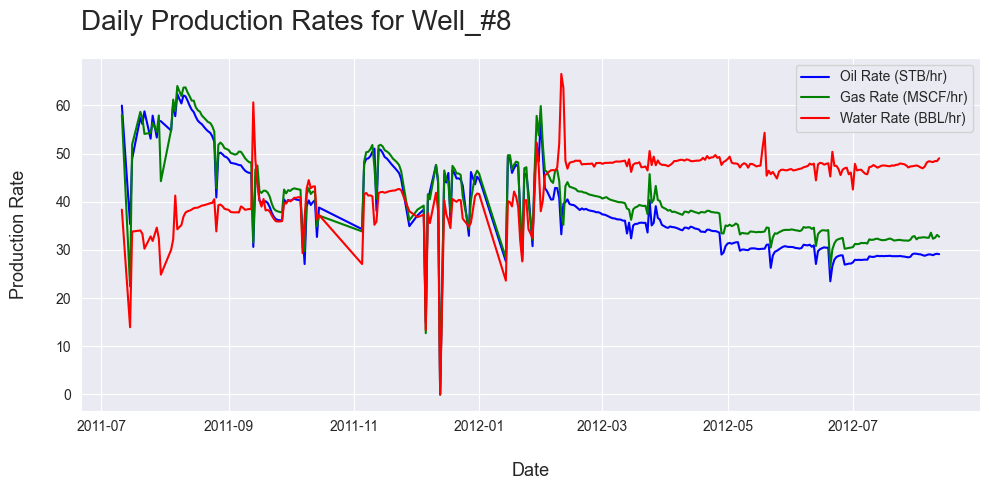

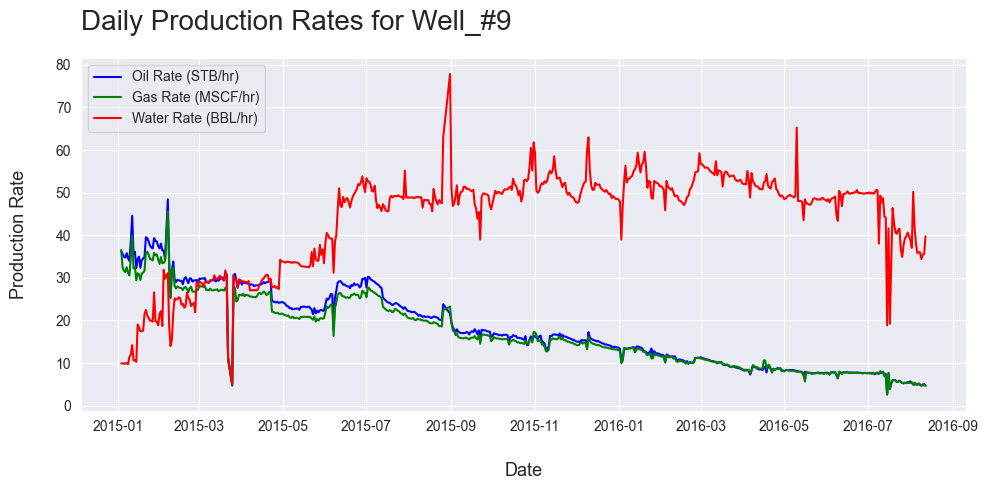

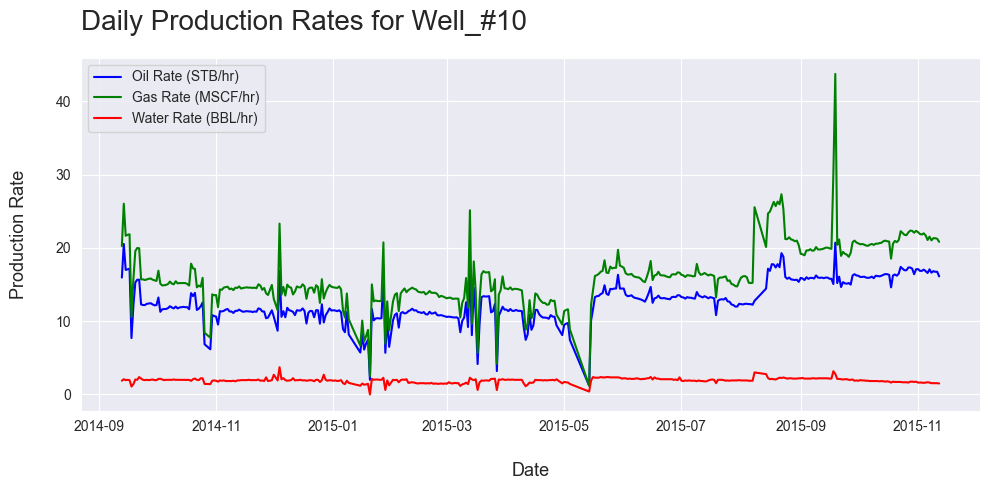

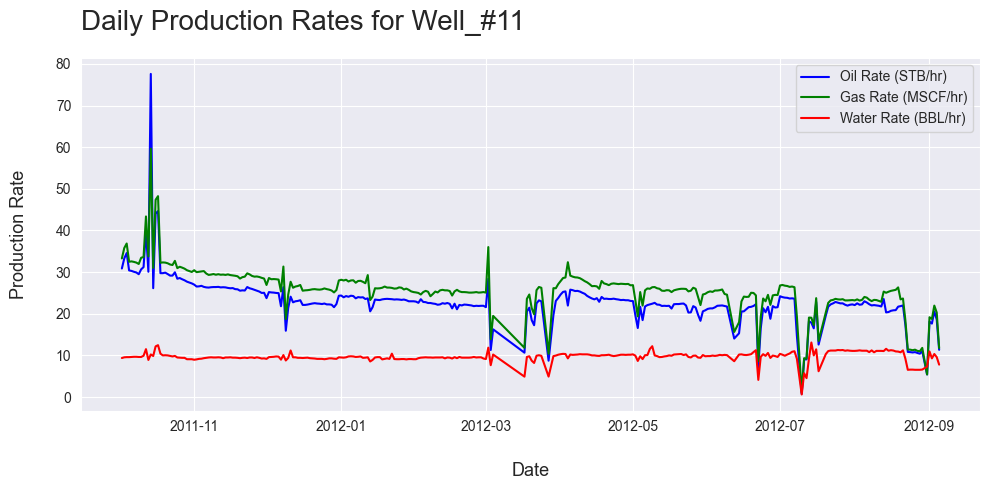

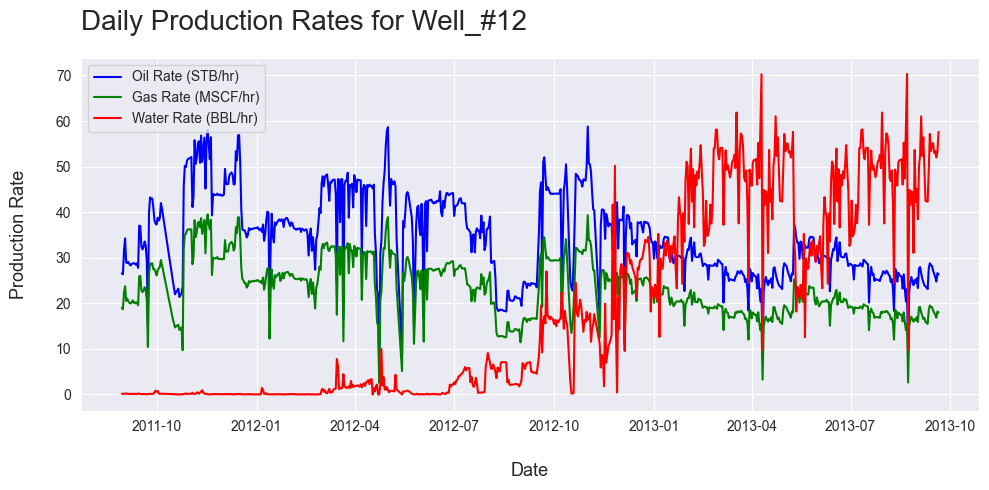

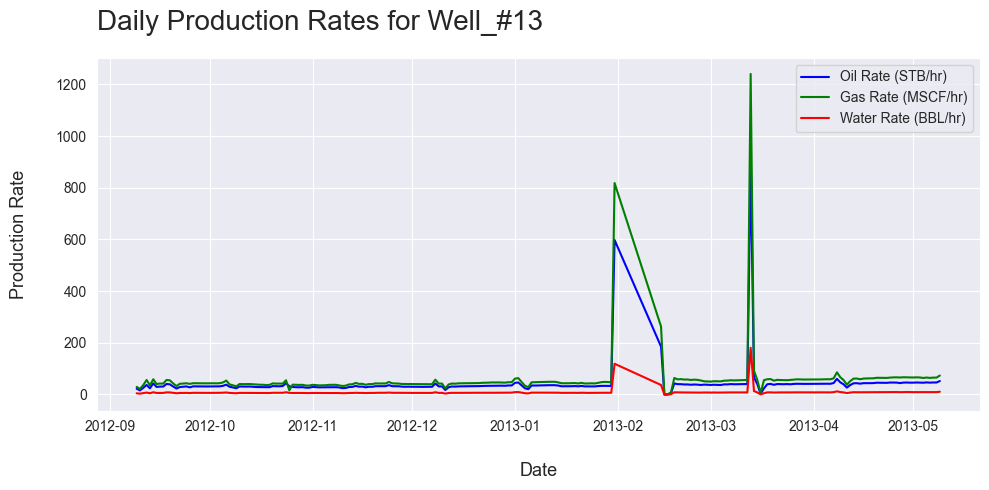

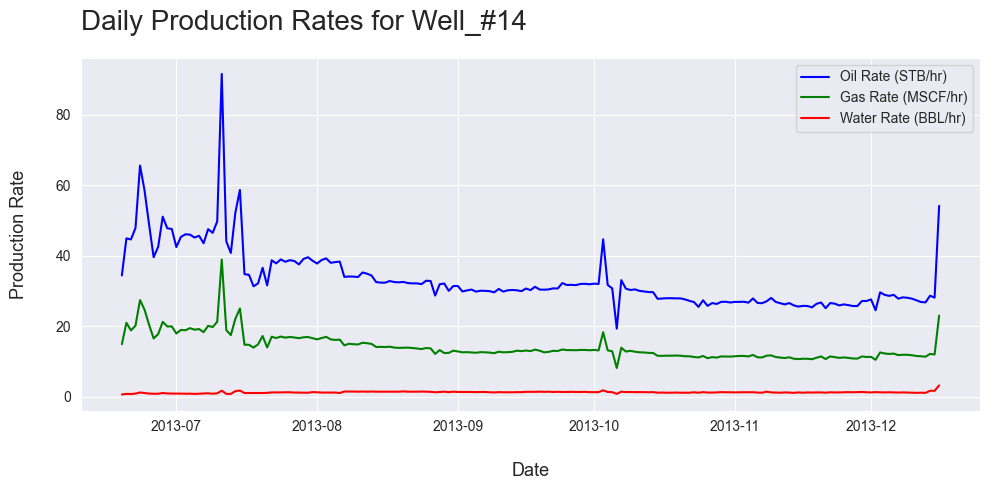

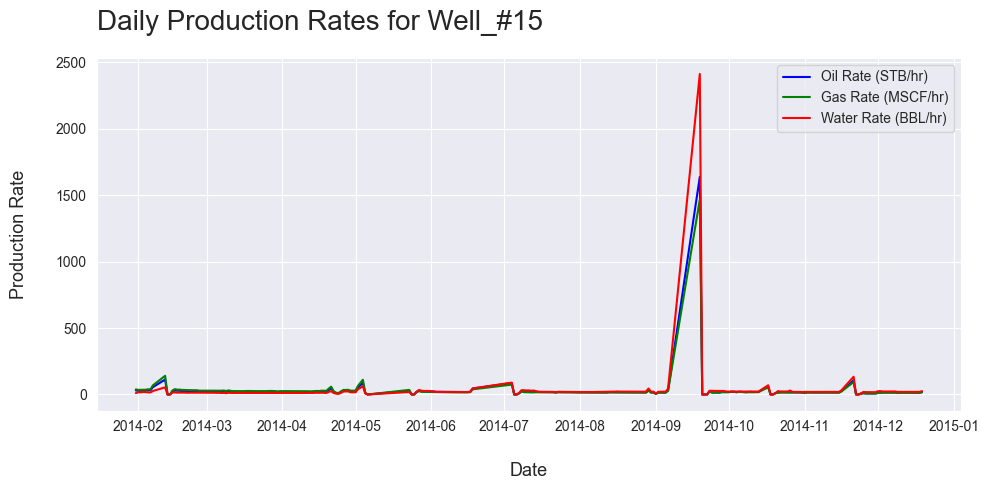

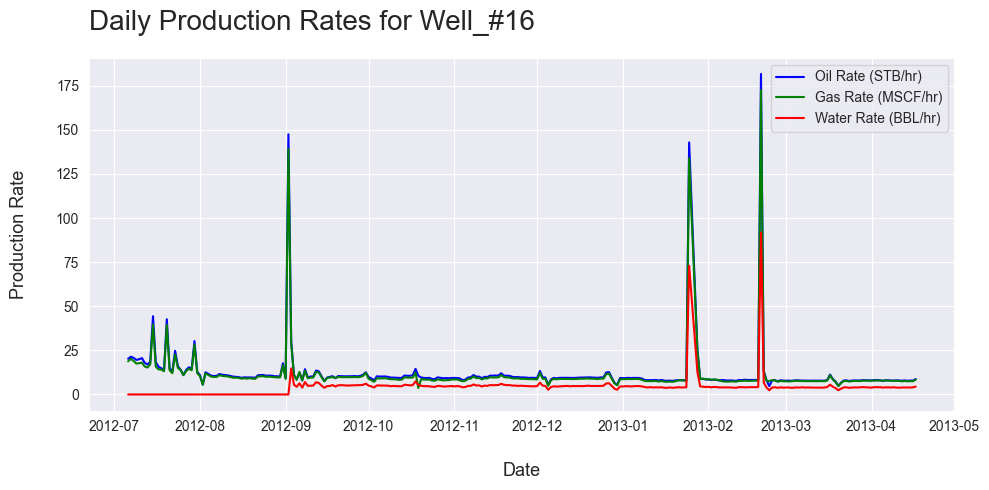

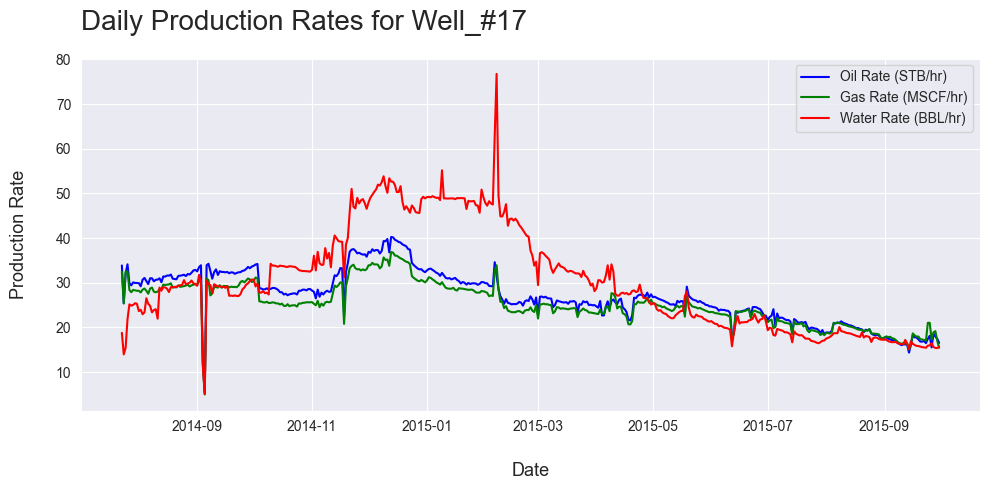

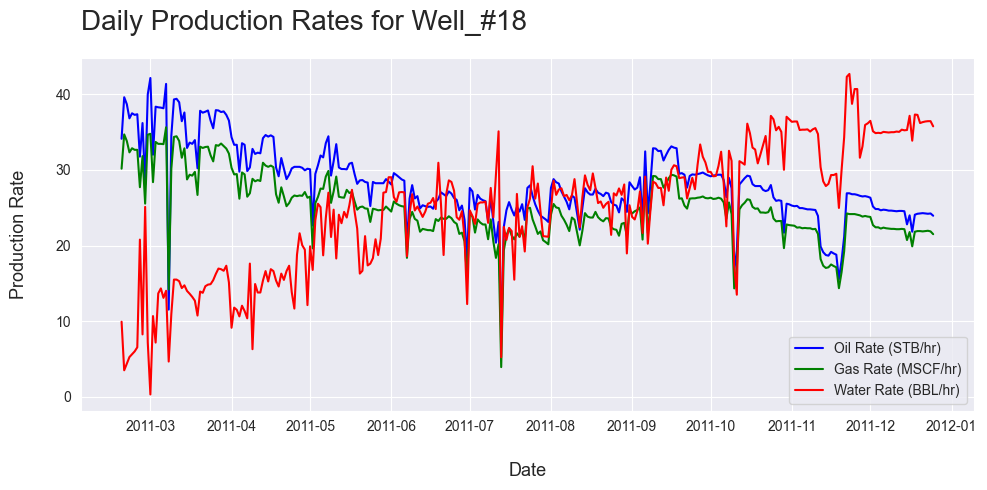

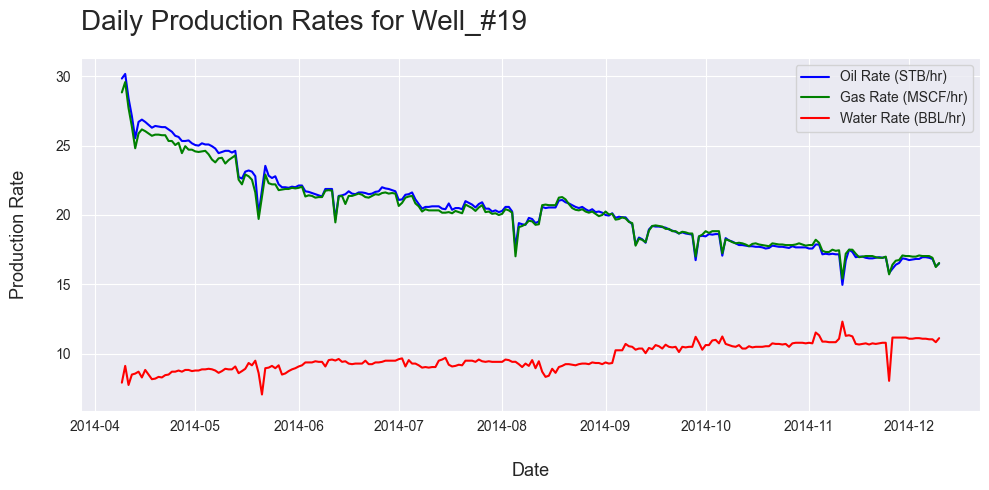

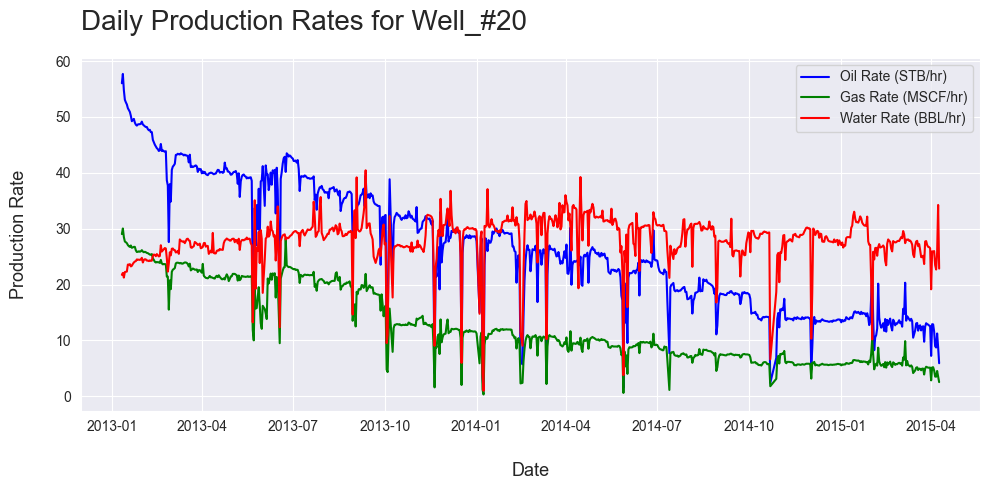

In [33]:
# Get unique well names
unique_wells = well_df['WELL_NAME'].unique()

# Process each well
for well_name in unique_wells:
    # Filter data for the current well
    well_data = well_df[well_df['WELL_NAME'] == well_name]

    # Plotting daily production rates
    plt.figure(figsize=(10, 5))
    plt.plot(well_data['PROD_DATE'], well_data['OIL_RATE'], label='Oil Rate (STB/hr)', color='blue')
    plt.plot(well_data['PROD_DATE'], well_data['GAS_RATE'], label='Gas Rate (MSCF/hr)', color='green')
    plt.plot(well_data['PROD_DATE'], well_data['WATER_RATE'], label='Water Rate (BBL/hr)', color='red')
    plt.xlabel("Date", fontsize=13, labelpad=20)
    plt.ylabel("Production Rate", fontsize=13, labelpad=20)
    plt.title(f"Daily Production Rates for {well_name}", fontsize=20, pad=20, loc="left")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'daily_production_{well_name.replace("#", "_")}.png', dpi=300)
    plt.show()

The plot shows oil rate declining steadily, water rate increasing gradually (suggesting an Increasing watercut trend for classification), and gas rate staying stable.

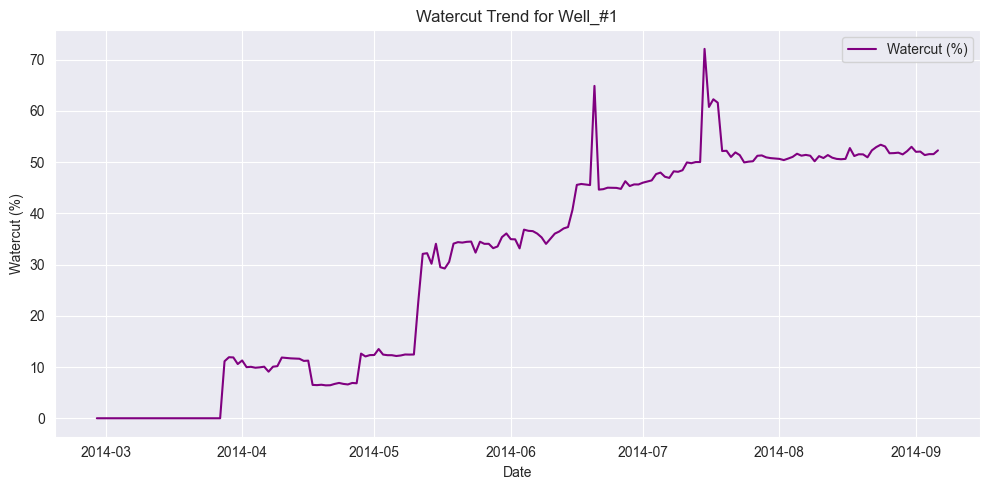

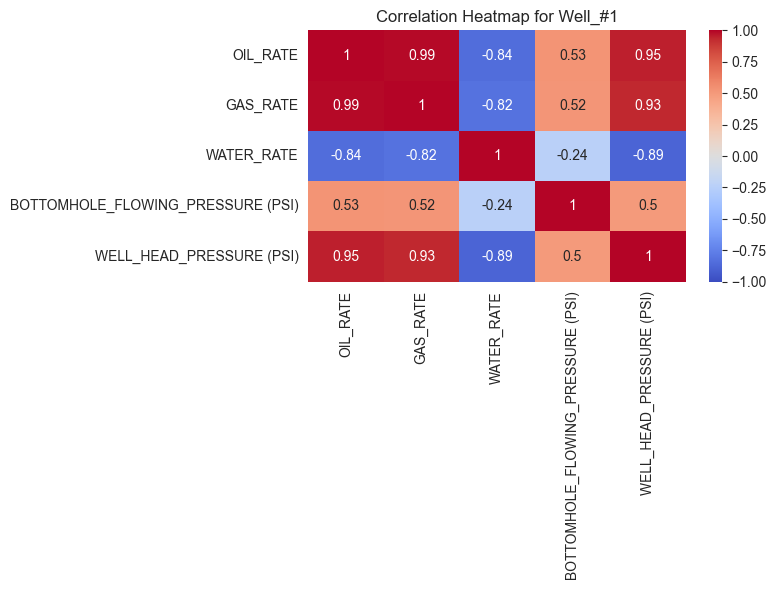

In [34]:
well_1_data = well_df[well_df['WELL_NAME'] == 'Well_#1'].copy()

# Calculate watercut (water rate / total fluid rate)
well_1_data['TOTAL_RATE'] = well_1_data['OIL_RATE'] + well_1_data['WATER_RATE']
well_1_data['WATERCUT'] = well_1_data['WATER_RATE'] / well_1_data['TOTAL_RATE'] * 100

# Plotting watercut over time
plt.figure(figsize=(10, 5))
plt.plot(well_1_data['PROD_DATE'], well_1_data['WATERCUT'], label='Watercut (%)', color='purple')
plt.xlabel("Date")
plt.ylabel("Watercut (%)")
plt.title("Watercut Trend for Well_#1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('watercut_trend_well_1.png', dpi=300)
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = well_1_data[['OIL_RATE', 'GAS_RATE', 'WATER_RATE', 'BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'WELL_HEAD_PRESSURE (PSI)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Well_#1")
plt.tight_layout()
plt.savefig('correlation_heatmap_well_1.png', dpi=300)
plt.show()

Oil and gas rates are highly correlated (0.99), showing that they tend to increase together. Wellhead pressure shows a strong positive link with both oil (0.95) and gas (0.93) rates. Whereas, water rate has a strong negative correlation with oil (−0.84), gas (−0.82), and wellhead pressure (−0.89), meaning increased water typically leads to lower production and pressure. Lastly, bottomhole flowing pressure is averegely positive with oil (0.53) and gas (0.52) rates.

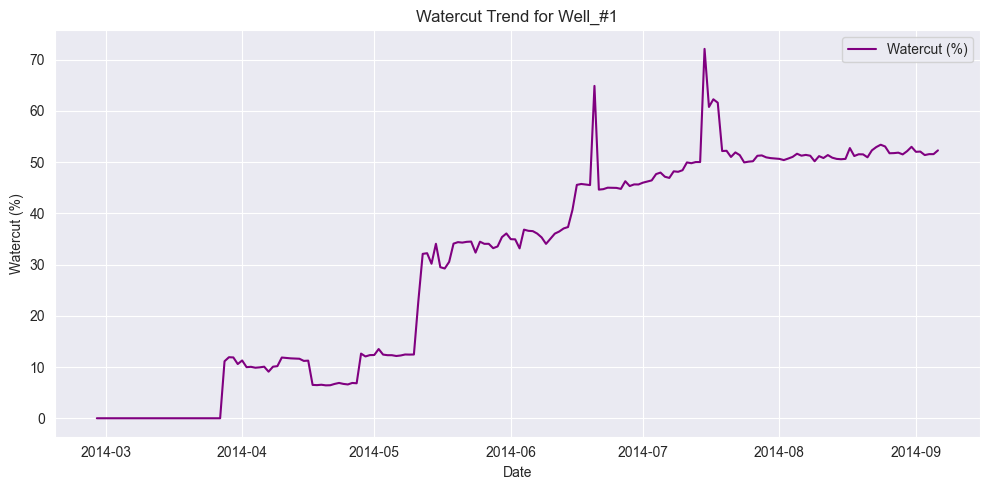

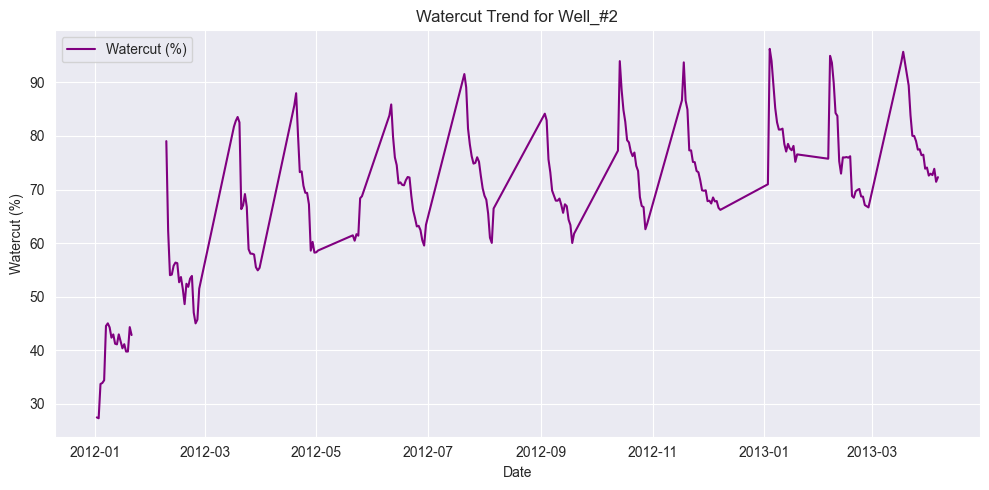

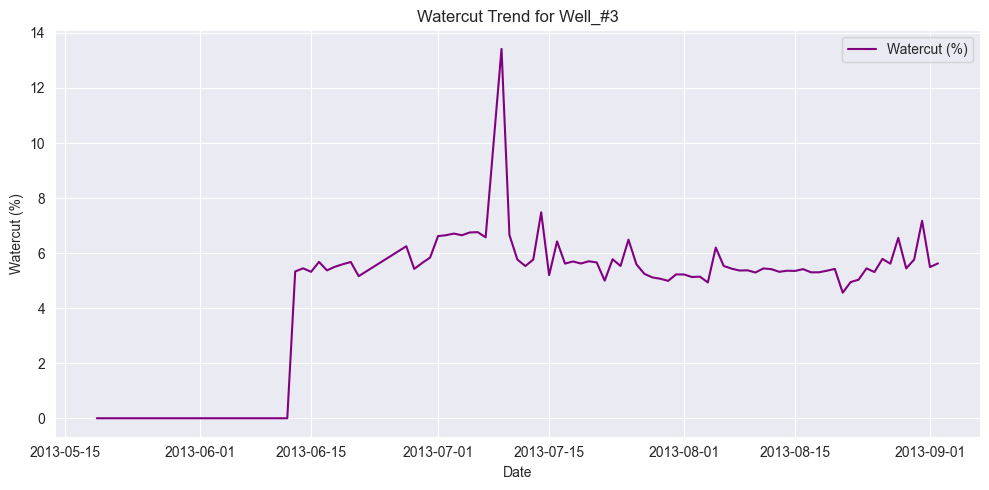

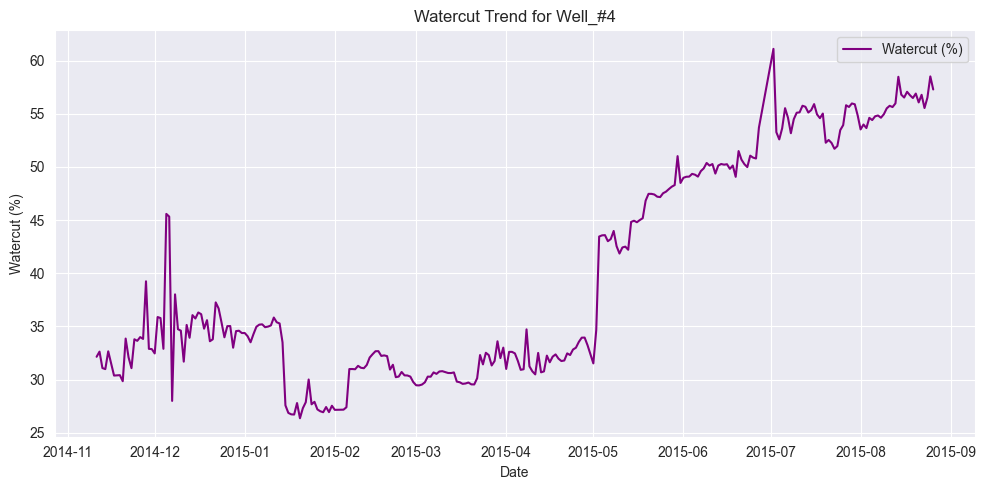

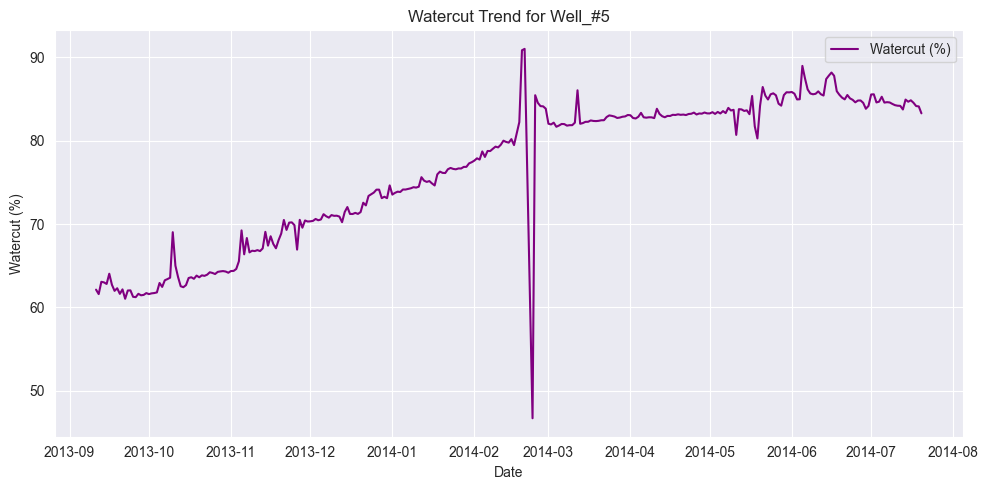

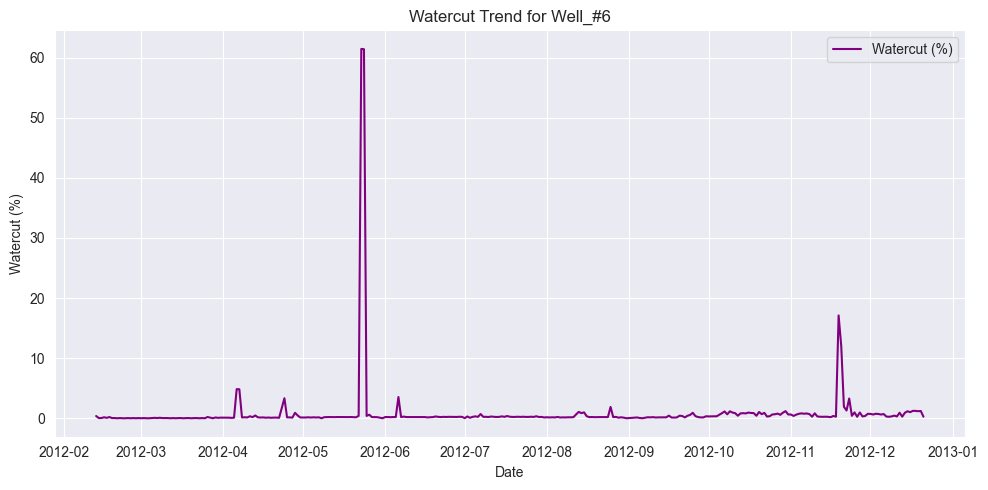

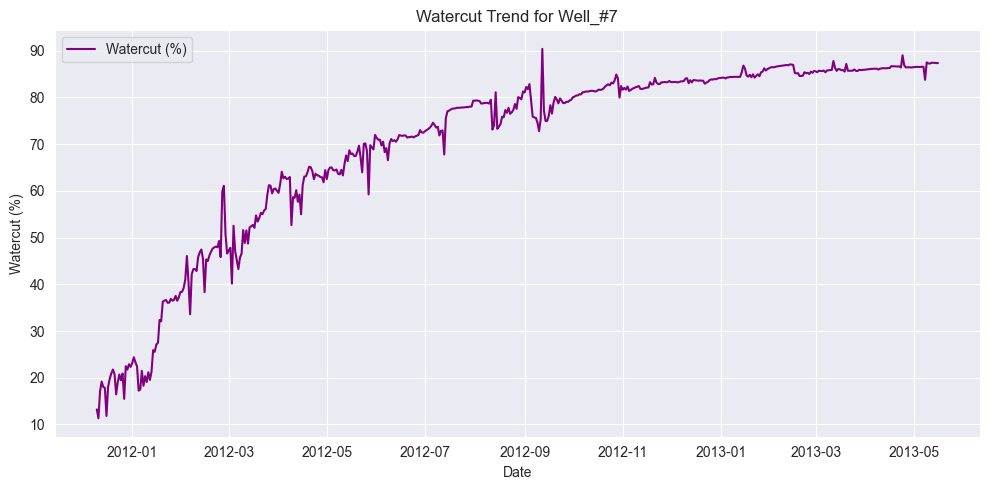

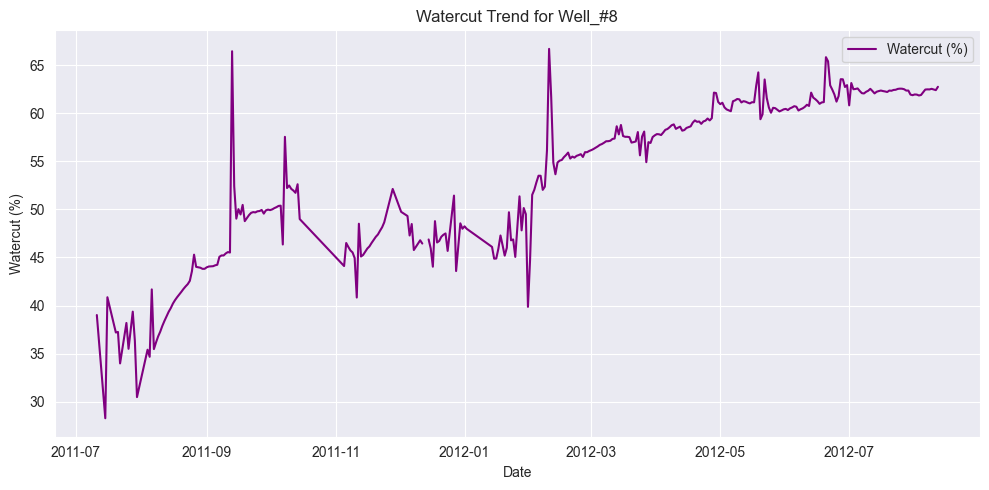

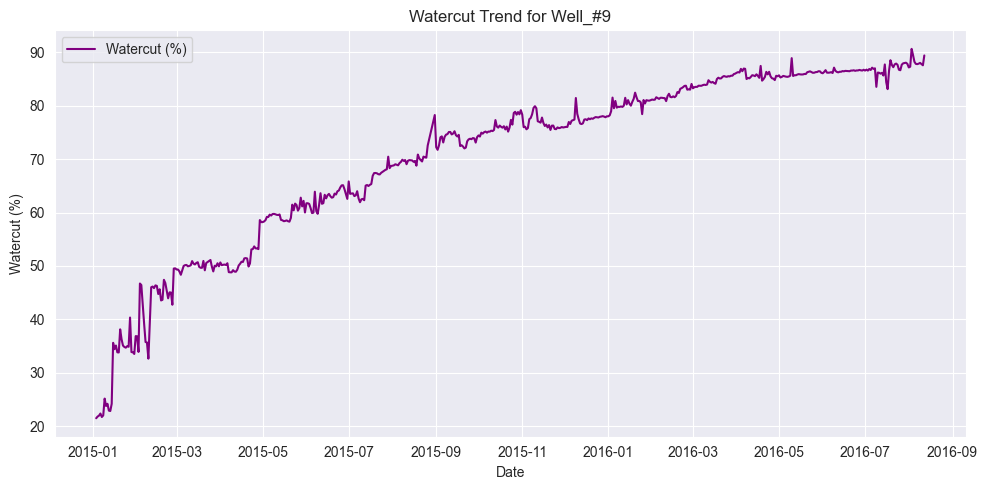

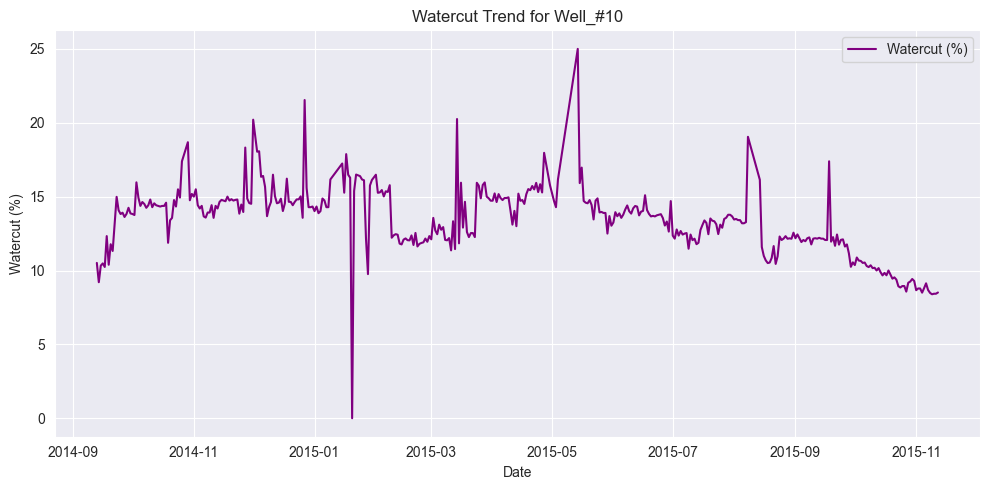

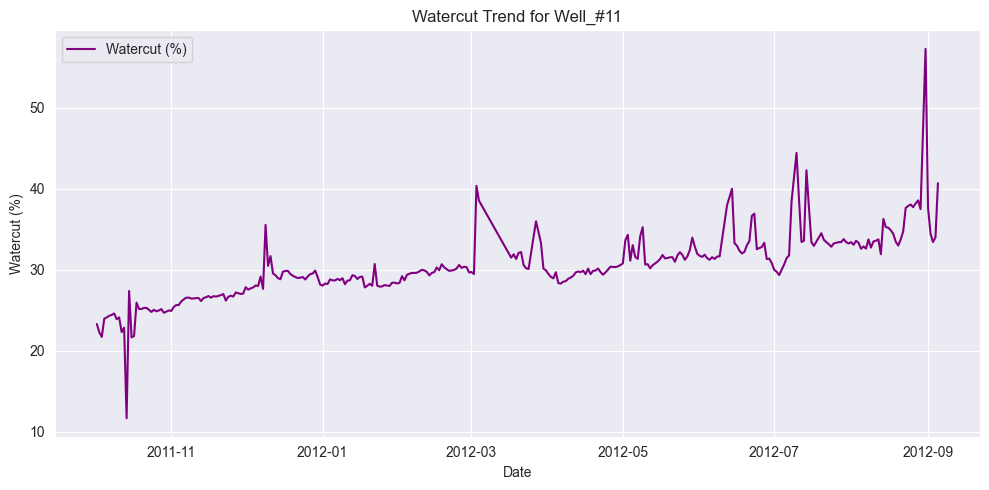

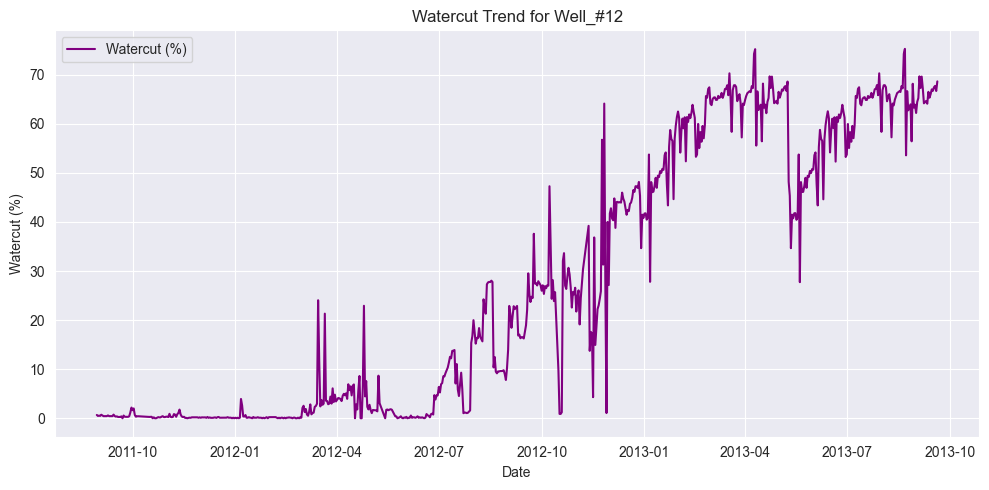

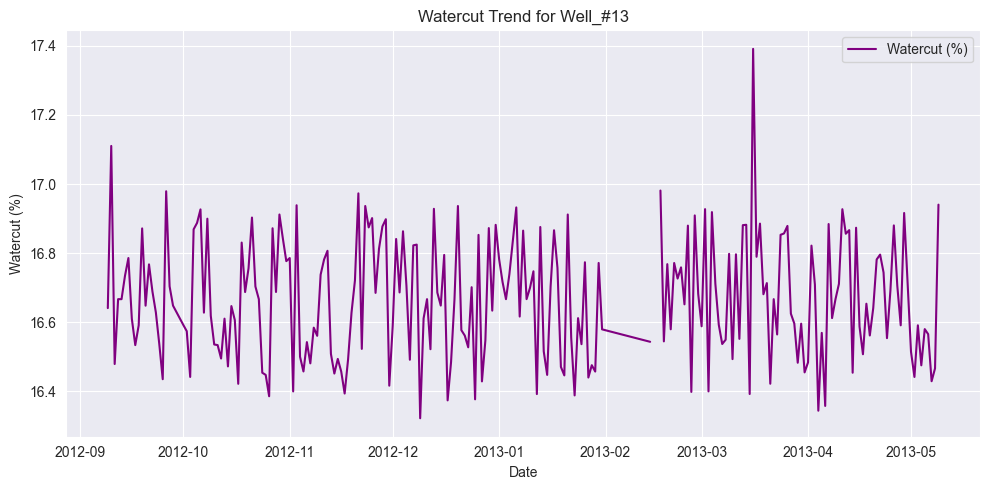

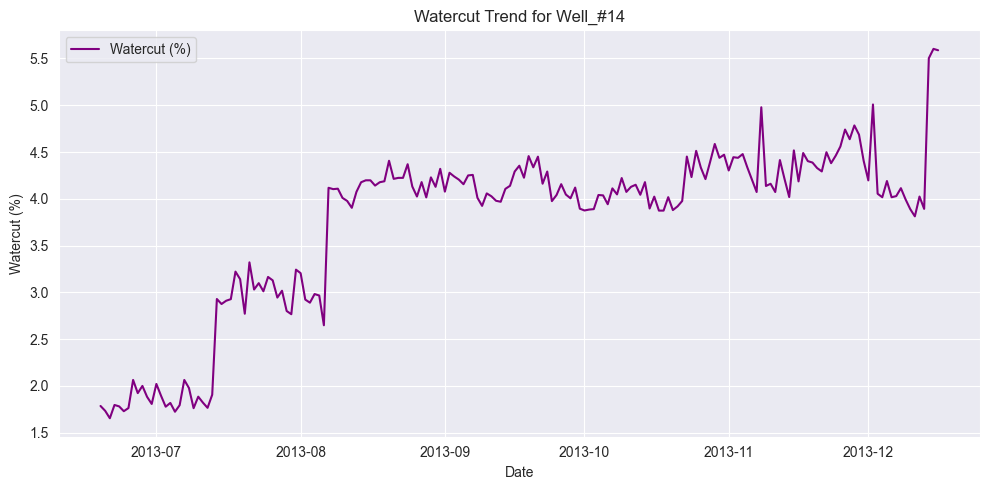

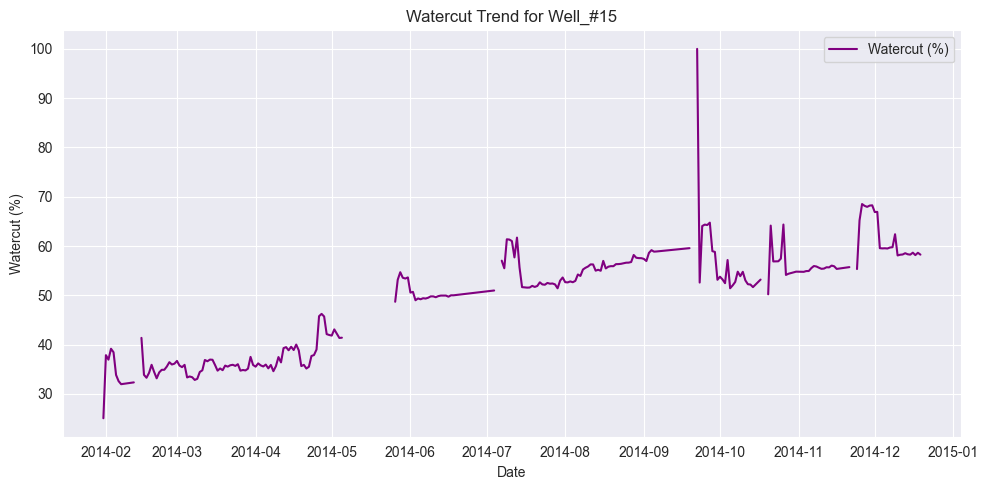

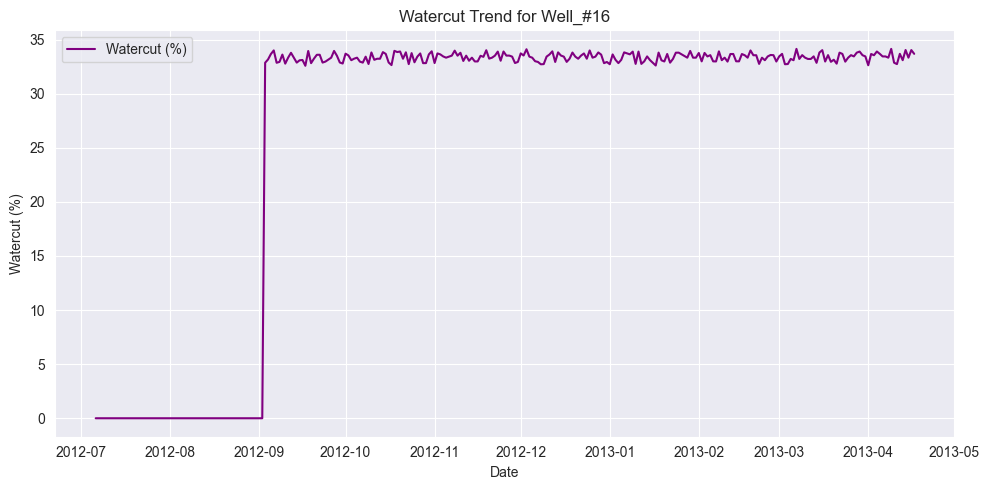

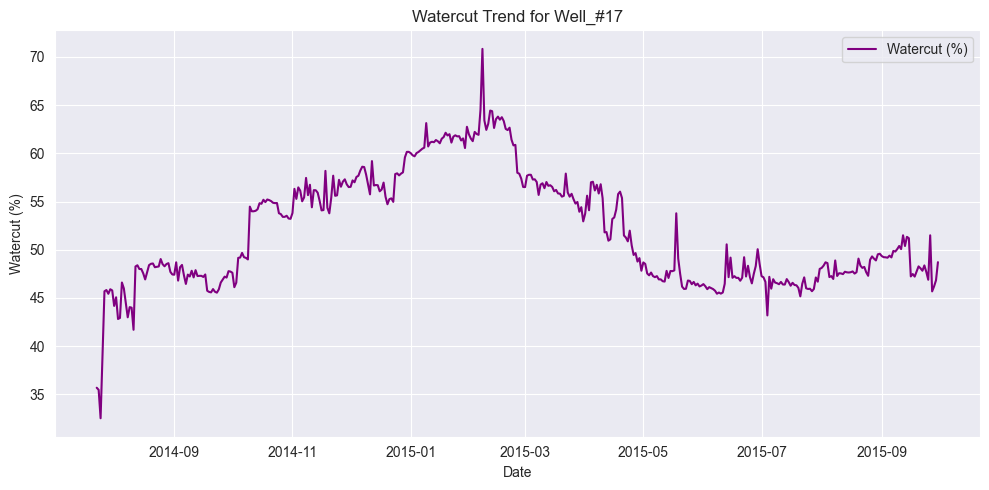

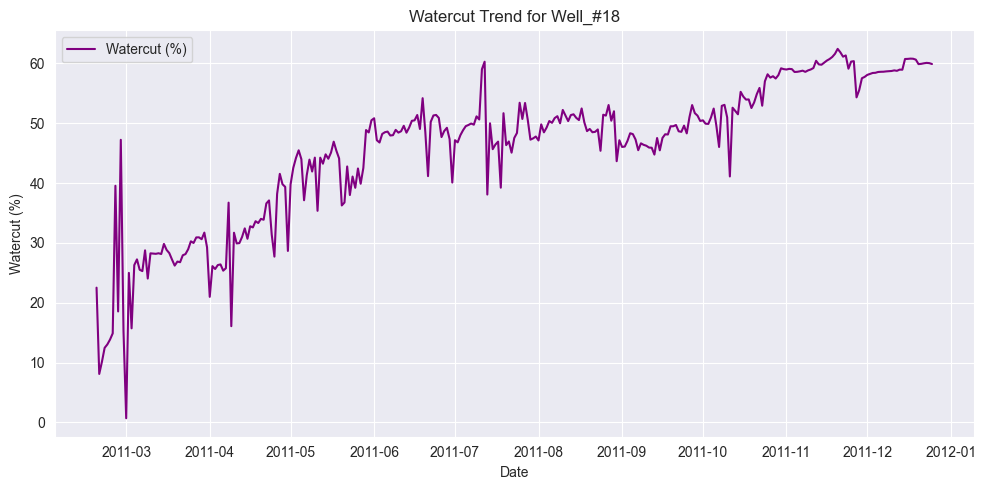

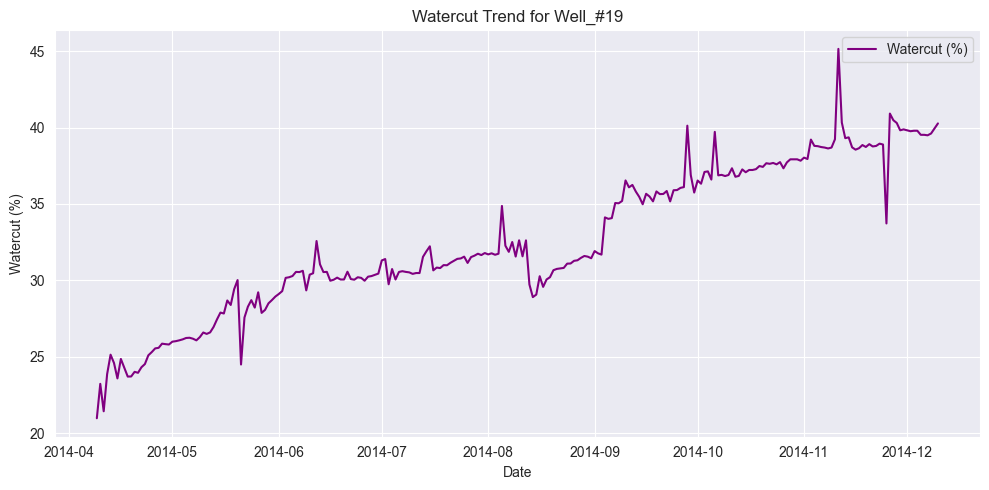

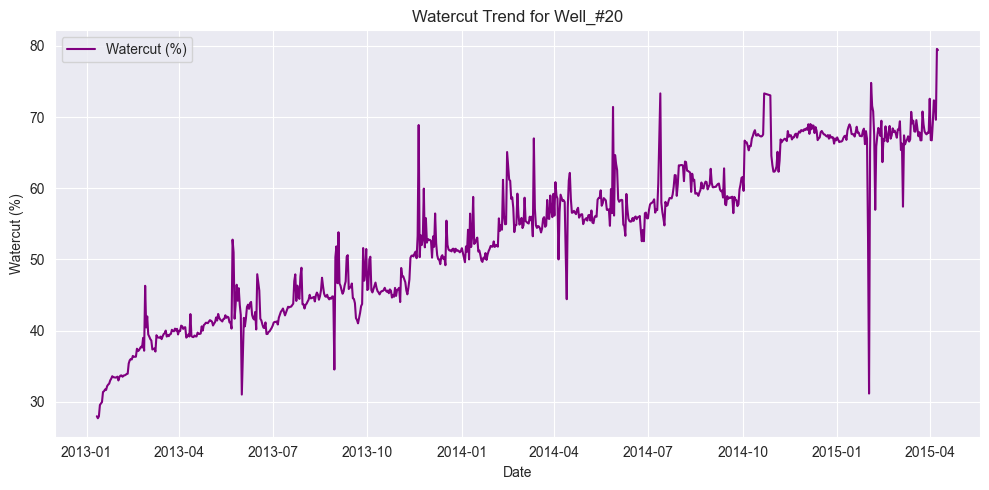

In [35]:
# Get unique well names
unique_wells = well_df['WELL_NAME'].unique()

# Process each well
for well_name in unique_wells:
    # Filter data for the current well
    well_data = well_df[well_df['WELL_NAME'] == well_name].copy()

    # Calculate watercut (water rate / total fluid rate)
    well_data['TOTAL_RATE'] = well_data['OIL_RATE'] + well_data['WATER_RATE']
    well_data['WATERCUT'] = well_data['WATER_RATE'] / well_data['TOTAL_RATE'] * 100

    # Plotting watercut over time
    plt.figure(figsize=(10, 5))
    plt.plot(well_data['PROD_DATE'], well_data['WATERCUT'], label='Watercut (%)', color='purple')
    plt.xlabel("Date")
    plt.ylabel("Watercut (%)")
    plt.title(f"Watercut Trend for {well_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'watercut_trend_{well_name.replace("#", "_")}.png', dpi=300)
    plt.show()

# LOGIC CLASSIFICATION OF ALL PARAMETER

## Classification Based on Logic

In [36]:
# Define functions for logic-based classification using classification_df
def classify_reservoir(well):
    max_bhp = well['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].max()
    best_match = None
    min_diff = 200
    for _, row in reservoir_df.iterrows():
        res_pressure = row['Current Average Reservoir Pressure (PSI)']
        if pd.notna(res_pressure):
            diff = abs(max_bhp - res_pressure)
            if diff < 200 and diff < min_diff:
                min_diff = diff
                best_match = row['Reservoir Name']
    return best_match if best_match else 'Unknown'

def classify_saturation(well, reservoir):
    if reservoir == 'Unknown':
        return 'Undetermined'
    res_data = reservoir_df[reservoir_df['Reservoir Name'] == reservoir].iloc[0]
    return 'Saturated' if res_data['Initial Reservoir Pressure (PSI)'] <= res_data['Bubble Point Pressure (PSI)'] else 'Undersaturated'

def classify_well_type(well):
    pressure_drop = well['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].max() - well['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].min()
    return 'GL' if pressure_drop > 1000 else 'NF'

def classify_production_type(well):
    oil_drop = well['OIL_RATE'].pct_change().abs().rolling(window=90).max()
    max_drop = oil_drop.max() if pd.notna(oil_drop).any() else 0
    return 'Unsteady' if max_drop > 0.5 else 'Steady'

def classify_gor_trend(well, reservoir):
    if reservoir == 'Unknown':
        return 'Undetermined'
    res_gor = reservoir_df[reservoir_df['Reservoir Name'] == reservoir]['Solution Gas-Oil-Ratio (SCF/BBL)'].iloc[0]
    avg_gor = well['GOR_ROLLING'].mean()
    return 'aSo/GOR' if pd.notna(avg_gor) and avg_gor > res_gor else 'bSo/GOR'

def classify_watercut_trend(well):
    watercut_trend = well['WATERCUT_DIFF'].mean()
    if pd.notna(watercut_trend):
        return 'Incr' if watercut_trend > 0 else 'Decr' if watercut_trend < 0 else 'Flat'
    return 'Flat'

def classify_pi_trend(well):
    pi_trend = well['PI_DIFF'].mean()
    if pd.notna(pi_trend):
        return 'Incr' if pi_trend > 0 else 'Decr' if pi_trend < 0 else 'Flat'
    return 'Flat'

In [55]:
print(well_df.columns)

Index(['PROD_DATE', 'WELL_NAME', 'ON_STREAM_HRS',
       'BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'DOWNHOLE_TEMPERATURE (deg F)',
       'ANNULUS_PRESS (PSI)', 'CHOKE_SIZE (%)', 'WELL_HEAD_PRESSURE (PSI)',
       'WELL_HEAD_TEMPERATURE (deg F)', 'CUMULATIVE_OIL_PROD (STB)',
       'CUMULATIVE_FORMATION_GAS_PROD (MSCF)',
       'CUMULATIVE_TOTAL_GAS_PROD (MSCF)', 'CUMULATIVE_WATER_PROD (BBL)',
       'OIL_RATE', 'GAS_RATE', 'WATER_RATE', 'GOR', 'PI', 'WATERCUT',
       'WATERCUT_DIFF', 'PI_DIFF', 'GOR_ROLLING', 'PI_ROLLING',
       'WATERCUT_ROLLING', 'PRESSURE_RATIO', 'MONTH', 'YEAR', 'DAY_OF_YEAR',
       'OIL_RATE_ROLLING', 'GAS_RATE_ROLLING', 'WATER_RATE_ROLLING'],
      dtype='object')


In [56]:
# Generate multi-output labels by combining classification_df and well_df data
labels = []
for well_name in classification_df['WELL_NAME'].unique():
    # Use classification_df for pressure-based classifications
    pressure_group = classification_df[classification_df['WELL_NAME'] == well_name]
    reservoir = classify_reservoir(pressure_group)
    saturation = classify_saturation(pressure_group, reservoir)
    well_type = classify_well_type(pressure_group)
    
    # Use well_df for rate-based classifications
    rate_group = well_df[well_df['WELL_NAME'] == well_name]
    prod_type = classify_production_type(rate_group)
    gor_trend = classify_gor_trend(rate_group, reservoir)
    watercut_trend = classify_watercut_trend(rate_group)
    pi_trend = classify_pi_trend(rate_group)
    
    labels.append([reservoir, saturation, well_type, prod_type, gor_trend, watercut_trend, pi_trend])

# Create DataFrame for labels
label_cols = ['Reservoir Name', 'Reservoir Type', 'Well Type', 'Production Type', 
              'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend']
multi_labels = pd.DataFrame(labels, columns=label_cols, index=classification_df['WELL_NAME'].unique())

In [57]:
# Merge and keep WELL_NAME as index
final_classification = classification_df.drop_duplicates(subset='WELL_NAME').merge(
    multi_labels, left_on='WELL_NAME', right_index=True
).set_index('WELL_NAME')

# Display only classification results
final_classification[label_cols].head(20)

Reservoir Name  Reservoir Type Well Type Production Type  \
WELL_NAME                                                            
Well_#1             JANI  Undersaturated        GL        Unsteady   
Well_#2             KEMA  Undersaturated        GL        Unsteady   
Well_#3             MAKO       Saturated        NF        Unsteady   
Well_#4             DEPU       Saturated        NF        Unsteady   
Well_#5             MAKO       Saturated        NF        Unsteady   
Well_#6             KEMA  Undersaturated        GL        Unsteady   
Well_#7             KEMA  Undersaturated        NF        Unsteady   
Well_#8             ACHI  Undersaturated        NF        Unsteady   
Well_#9             DEPU       Saturated        GL        Unsteady   
Well_#10            JANI  Undersaturated        NF        Unsteady   
Well_#11            DEPU       Saturated        NF        Unsteady   
Well_#12            ACHI  Undersaturated        GL        Unsteady   
Well_#13            DEPU       Saturated        NF        Unsteady   
Well_#14            MAKO       Saturated        NF        Unsteady   
Well_#15            KEMA  Undersaturated        GL          Steady   
Well_#16            KEMA  Undersaturated        GL        Unsteady   
Well_#17            DEPU       Saturated        NF        Unsteady   
Well_#18            ACHI  Undersaturated        GL        Unsteady   
Well_#19            KEMA  Undersaturated        NF        Unsteady   
Well_#20            MAKO       Saturated        GL        Unsteady   

          Formation GOR Trend Watercut Trend Oil Productivity Index Trend  
WELL_NAME                                                                  
Well_#1               bSo/GOR           Incr                         Incr  
Well_#2               bSo/GOR           Incr                         Decr  
Well_#3               bSo/GOR           Decr                         Incr  
Well_#4               bSo/GOR           Incr                         Incr  
Well_#5               bSo/GOR           Incr                         Decr  
Well_#6               bSo/GOR           Decr                         Decr  
Well_#7               bSo/GOR           Incr                         Incr  
Well_#8               bSo/GOR           Decr                         Incr  
Well_#9               bSo/GOR           Incr                         Decr  
Well_#10              bSo/GOR           Decr                         Incr  
Well_#11              bSo/GOR           Incr                         Incr  
Well_#12              bSo/GOR           Incr                         Incr  
Well_#13              bSo/GOR           Decr                         Incr  
Well_#14              bSo/GOR           Decr                         Decr  
Well_#15              bSo/GOR           Incr                         Decr  
Well_#16              bSo/GOR           Decr                         Decr  
Well_#17              bSo/GOR           Incr                         Incr  
Well_#18              bSo/GOR           Incr                         Decr  
Well_#19              bSo/GOR           Decr                         Decr  
Well_#20              bSo/GOR           Incr                         Decr

## Classification Visualization

In [58]:
# 1. Wells per Reservoir Name
print(" Wells per Reservoir Name:\n")
display(final_classification['Reservoir Name'].value_counts().to_frame(name='Well Count'))

# 2. Reservoir Type Distribution
print("\n Reservoir Type Distribution:\n")
display(final_classification['Reservoir Type'].value_counts().to_frame(name='Count'))

# 3. Well Type Distribution
print("\n Well Type Distribution:\n")
display(final_classification['Well Type'].value_counts().to_frame(name='Count'))

# 4. Production Type Distribution
print("\n Production Type Distribution:\n")
display(final_classification['Production Type'].value_counts().to_frame(name='Count'))

# 5. Formation GOR Trend (from classification)
print("\n Formation GOR Trend Classification:\n")
display(final_classification['Formation GOR Trend'].value_counts().to_frame(name='Count'))

# 6. Watercut Trend
print("\n Watercut Trend Classification:\n")
display(final_classification['Watercut Trend'].value_counts().to_frame(name='Count'))

# 7. Oil Productivity Index (PI) Trend
print("\n PI Trend Classification:\n")
display(final_classification['Oil Productivity Index Trend'].value_counts().to_frame(name='Count'))

 Wells per Reservoir Name:



Well Count
Reservoir Name            
KEMA                     6
DEPU                     5
MAKO                     4
ACHI                     3
JANI                     2


 Reservoir Type Distribution:



Count
Reservoir Type       
Undersaturated     11
Saturated           9


 Well Type Distribution:



Count
Well Type       
NF            11
GL             9


 Production Type Distribution:



Count
Production Type       
Unsteady            19
Steady               1


 Formation GOR Trend Classification:



Count
Formation GOR Trend       
bSo/GOR                 20


 Watercut Trend Classification:



Count
Watercut Trend       
Incr               12
Decr                8


 PI Trend Classification:



Count
Oil Productivity Index Trend       
Incr                             10
Decr                             10

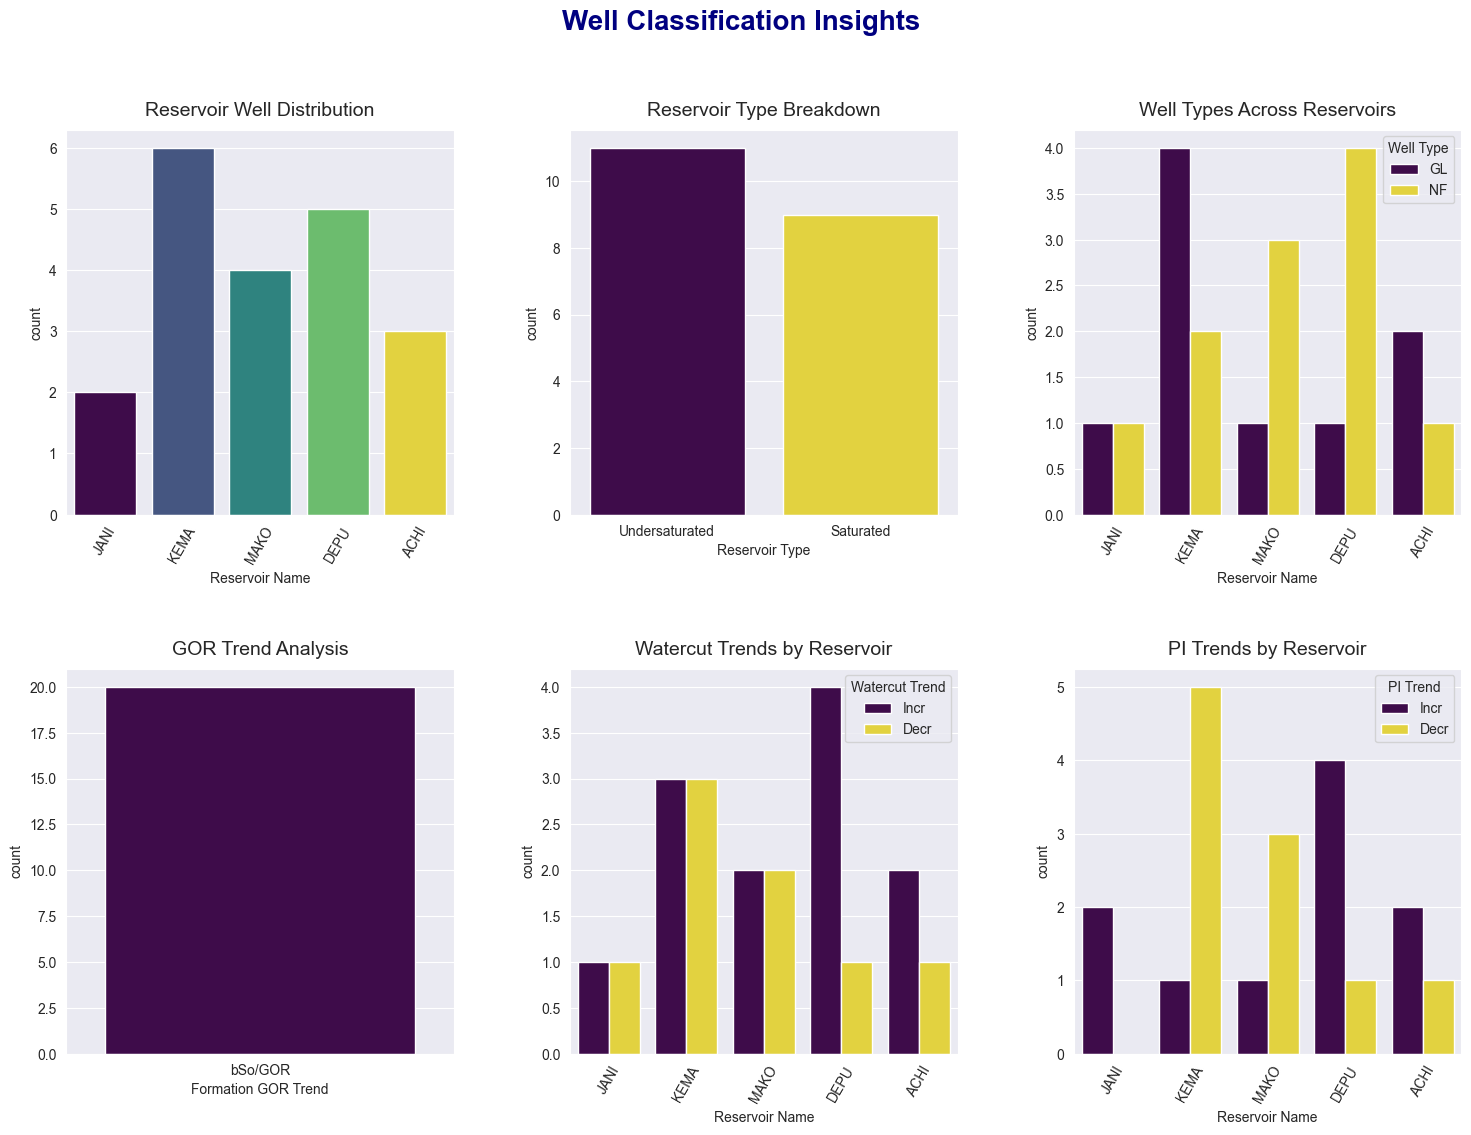

In [59]:
# Set up plot style with a custom theme
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'wspace': 0.3, 'hspace': 0.4})
fig.suptitle("Well Classification Insights", fontsize=20, fontweight='bold', color='navy')

# Custom gradient colormap
cmap = plt.cm.get_cmap('viridis')

# 1. Count of wells per reservoir (top-left)
sns.countplot(data=final_classification, x="Reservoir Name", ax=axs[0, 0], palette=cmap(np.linspace(0, 1, len(final_classification['Reservoir Name'].unique()))))
axs[0, 0].set_title("Reservoir Well Distribution", fontsize=14, pad=10)
axs[0, 0].tick_params(axis='x', rotation=60, labelsize=10)

# 2. Distribution of reservoir types (top-middle)
sns.countplot(data=final_classification, x="Reservoir Type", ax=axs[0, 1], palette=cmap(np.linspace(0, 1, len(final_classification['Reservoir Type'].unique()))))
axs[0, 1].set_title("Reservoir Type Breakdown", fontsize=14, pad=10)
axs[0, 1].tick_params(axis='x', labelsize=10)

# 3. Well Type by Reservoir (top-right)
sns.countplot(data=final_classification, x="Reservoir Name", hue="Well Type", ax=axs[0, 2], palette=cmap(np.linspace(0, 1, len(final_classification['Well Type'].unique()))))
axs[0, 2].set_title("Well Types Across Reservoirs", fontsize=14, pad=10)
axs[0, 2].tick_params(axis='x', rotation=60, labelsize=10)
axs[0, 2].legend(title='Well Type', title_fontsize=10)

# 4. Formation GOR Trend Distribution (bottom-left)
sns.countplot(data=final_classification, x="Formation GOR Trend", ax=axs[1, 0], palette=cmap(np.linspace(0, 1, len(final_classification['Formation GOR Trend'].unique()))))
axs[1, 0].set_title("GOR Trend Analysis", fontsize=14, pad=10)
axs[1, 0].tick_params(axis='x', labelsize=10)

# 5. Watercut Trend by Reservoir (bottom-middle)
sns.countplot(data=final_classification, x="Reservoir Name", hue="Watercut Trend", ax=axs[1, 1], palette=cmap(np.linspace(0, 1, len(final_classification['Watercut Trend'].unique()))))
axs[1, 1].set_title("Watercut Trends by Reservoir", fontsize=14, pad=10)
axs[1, 1].tick_params(axis='x', rotation=60, labelsize=10)
axs[1, 1].legend(title='Watercut Trend', title_fontsize=10)

# 6. Oil Productivity Index Trend by Reservoir (bottom-right)
sns.countplot(data=final_classification, x="Reservoir Name", hue="Oil Productivity Index Trend", ax=axs[1, 2], palette=cmap(np.linspace(0, 1, len(final_classification['Oil Productivity Index Trend'].unique()))))
axs[1, 2].set_title("PI Trends by Reservoir", fontsize=14, pad=10)
axs[1, 2].tick_params(axis='x', rotation=60, labelsize=10)
axs[1, 2].legend(title='PI Trend', title_fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Classification Model

In [ ]:
#Prepare ML Data
critical_cols = ['OIL_RATE', 'GAS_RATE', 'WATER_RATE', 'BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'WELL_HEAD_PRESSURE (PSI)',
                 'GOR_ROLLING', 'PI_ROLLING', 'WATERCUT_ROLLING']
#Generate "Ground Truth" Labels using the logic functions
unique_wells_for_labels = well_df['WELL_NAME'].unique()
ground_truth_classifications = []
for well_name in unique_wells_for_labels:
    group = well_df[well_df['WELL_NAME'] == well_name]
    if not group.empty and group[critical_cols].notna().any().any():
        reservoir = classify_reservoir(group)
        saturation = classify_saturation(group, reservoir)
        well_type = classify_well_type(group)
        prod_type = classify_production_type(group)
        gor_trend = classify_gor_trend(group, reservoir)
        watercut_trend = classify_watercut_trend(group)
        pi_trend = classify_pi_trend(group)
        ground_truth_classifications.append([well_name, reservoir, saturation, well_type, prod_type, gor_trend, watercut_trend, pi_trend])

ground_truth_df = pd.DataFrame(ground_truth_classifications, columns=['WELL_NAME', 'Reservoir Name', 'Reservoir Type', 'Well Type', 'Production Type',
                                                                    'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend'])

# Using the pre-classified data (ground_truth_df) and merge with last day features
well_df_last_day = well_df.groupby('WELL_NAME').last().reset_index()
ml_data = pd.merge(well_df_last_day, ground_truth_df, on='WELL_NAME', how='inner')

# Define features and targets
features = [
    'MONTH', 'YEAR', 'DAY_OF_YEAR',
    'OIL_RATE_ROLLING', 'GAS_RATE_ROLLING', 'WATER_RATE_ROLLING',
    'PRESSURE_RATIO', 'GOR_ROLLING', 'PI_ROLLING'
]

targets = [
    'Reservoir Name', 'Reservoir Type', 'Well Type', 'Production Type',
    'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend'
]

# Clean data
ml_data = ml_data.dropna(subset=features + targets)

# Encode Targets
label_encoders = {col: LabelEncoder().fit(ml_data[col]) for col in targets}
y_encoded = pd.DataFrame({col: label_encoders[col].transform(ml_data[col]) for col in targets})

# Train/Test Split 
try:
    X_train, X_test, y_train, y_test = train_test_split(
        ml_data[features], 
        y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded[targets[0]]  # Try stratified first
    )
except ValueError:
    print(" Warning: Falling back to non-stratified split (some classes too small)")
    X_train, X_test, y_train, y_test = train_test_split(
        ml_data[features], 
        y_encoded,
        test_size=0.2,
        random_state=42
        # No stratification
    )

# Train Model
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1  # Use all CPU cores
)
model.fit(X_train, y_train)

# Evaluation
print("Model Evaluation Metrics:\n")
y_pred = model.predict(X_test)

for i, col in enumerate(targets):
    print(f"\n {col}")
    print(f"Accuracy: {accuracy_score(y_test[col], y_pred[:,i]):.3f}")
    print("Classification Report:")
    print(classification_report(
        label_encoders[col].inverse_transform(y_test[col]),
        label_encoders[col].inverse_transform(y_pred[:,i]),
        zero_division=0
    ))

# Save Model
joblib.dump({
    'model': model,
    'encoders': label_encoders,
    'features': features
}, 'well_classifier.pkl')

Model Evaluation Metrics:


 Reservoir Name
Accuracy: 0.000
Classification Report:
              precision    recall  f1-score   support

        ACHI       0.00      0.00      0.00       0.0
        DEPU       0.00      0.00      0.00       0.0
        KEMA       0.00      0.00      0.00       3.0
        MAKO       0.00      0.00      0.00       1.0
     Unknown       0.00      0.00      0.00       0.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0


 Reservoir Type
Accuracy: 0.750
Classification Report:
                precision    recall  f1-score   support

     Saturated       0.00      0.00      0.00         1
Undersaturated       0.75      1.00      0.86         3

      accuracy                           0.75         4
     macro avg       0.38      0.50      0.43         4
  weighted avg       0.56      0.75      0.64         4


 Well Type
Accuracy: 0.500
Class

['well_classifier.pkl']